# Time Series Forecasting: PM2.5 Levels in Bogotá

## **Authors:**
- Alejandra Valle Fernandez
- Juan Guillermo Gómez

## Project Overview

This project aims to implement a time series model to forecast daily PM2.5 levels in Bogotá for the next 7 days. PM2.5 was chosen due to its direct impact on public health and its strong correlation with the Air Quality Index (AQI). The analysis covers data selection, exploratory data analysis, stationarity transformations, autocorrelation analysis, and baseline model validation.

## Dataset Selection and Characterization

**Latin America Weather and Air Quality Data**

- **Source**: Kaggle (https://www.kaggle.com/datasets/anycaroliny/latin-america-weather-and-air-quality-data)
- **Content**: Two CSV files from the Open-Meteo API with weather and air quality data for various Latin American cities.
- **Frequency**: Daily data.
- **Parameters**: Country/city names, latitude/longitude, PM10, PM2.5, Carbon monoxide, Nitrogen dioxide, Sulphur dioxide, Ozone levels.

### Key Characteristics (Bogotá PM2.5)

| Characteristic | Description |
|---|---|
| Frequency | Daily |
| Main Variable | PM2.5 Concentration (µg/m³) |
| Observation Period | Continuous (August 2022 - April 2024), no missing data |
| Data Quality | No null values, few outliers after capping |

**More Info Phase 1:**
- https://colab.research.google.com/drive/15sAmOpCAspJA7G9L7TKSHTctNotpIN1H?usp=sharing

## **PHASE 2 OBJECTIVES**
Upon completion of this phase, the student will demonstrate the ability to:

- Implement ARIMA/SARIMA models with automatic and manual parameterization
- Configure exponential smoothing models with optimized parameters
- Apply traditional ML techniques with robust feature engineering
- Perform comparative benchmarking between 8 different models
- Identify the best model based on robust metrics and comprehensive diagnostics

## **Install Libraries**

In [ ]:
!pip install -U mlforecast utilsforecast statsforecast --quiet
!pip install window-ops xgboost lightgbm
!pip install optuna
!pip install rich

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Basic Models
from statsforecast import StatsForecast
from statsforecast.models import Holt, HoltWinters
from statsforecast.models import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from rich.console import Console
from scipy import stats
# ML
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from utilsforecast.preprocessing import fill_gaps
from mlforecast.target_transforms import Differences
from mlforecast import MLForecast
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from mlforecast.auto import AutoLightGBM, AutoCatboost, AutoXGBoost, AutoRandomForest, AutoLinearRegression, AutoMLForecast, AutoModel
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
import xgboost as xgb
import lightgbm as lgb
import optuna

console = Console()

In [ ]:
df_daily_air_quality = pd.read_csv("https://storage.googleapis.com/questionsanswersproject/time%20series/df_daily_air_quality_bogota.csv")
console.print(df_daily_air_quality.shape)
console.print(df_daily_air_quality.info())
df_daily_air_quality.head(10)

(626, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    626 non-null    object 
 1   pm2_5   626 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.9+ KB


None

,date,pm2_5
0,2022-08-04,12.6
1,2022-08-05,14.3
2,2022-08-06,16.6
3,2022-08-07,11.1
4,2022-08-08,12.8
5,2022-08-09,10.3
6,2022-08-10,6.8
7,2022-08-11,7.6
8,2022-08-12,12.5
9,2022-08-13,11.0


In [ ]:
df_daily_air_quality_bogota_formated_by_models = df_daily_air_quality.copy()
df_daily_air_quality_bogota_formated_by_models.head()

,date,pm2_5
0,2022-08-04,12.6
1,2022-08-05,14.3
2,2022-08-06,16.6
3,2022-08-07,11.1
4,2022-08-08,12.8


In [ ]:
# Data for nixtla format
df_daily_air_quality_bogota_formated_by_models.rename(columns={'date': 'ds', 'pm2_5': 'y'}, inplace=True)

df_daily_air_quality_bogota_formated_by_models['unique_id'] = 'Bogota_PM25'
df_daily_air_quality_bogota_formated_by_models['ds'] = pd.to_datetime(df_daily_air_quality_bogota_formated_by_models['ds'])
df_daily_air_quality_bogota_formated_by_models.head()

,ds,y,unique_id
0,2022-08-04,12.6,Bogota_PM25
1,2022-08-05,14.3,Bogota_PM25
2,2022-08-06,16.6,Bogota_PM25
3,2022-08-07,11.1,Bogota_PM25
4,2022-08-08,12.8,Bogota_PM25


## **Train / Test Dataset**

In [ ]:
train_size = int(len(df_daily_air_quality_bogota_formated_by_models) * 0.89)
df_daily_air_quality_bogota_train = df_daily_air_quality_bogota_formated_by_models[:train_size]
df_daily_air_quality_bogota_test = df_daily_air_quality_bogota_formated_by_models[train_size:]

console.print(f"  Training: {len(df_daily_air_quality_bogota_train)} obs ({df_daily_air_quality_bogota_train['ds'].min().date()} to {df_daily_air_quality_bogota_train['ds'].max().date()})")
console.print(f"  Validation:    {len(df_daily_air_quality_bogota_test)} obs ({df_daily_air_quality_bogota_test['ds'].min().date()} to {df_daily_air_quality_bogota_test['ds'].max().date()})")
df_daily_air_quality_bogota_train.head()

Training: 557 obs (2022-08-04 to 2024-02-11)

Validation:    69 obs (2024-02-12 to 2024-04-20)

,ds,y,unique_id
0,2022-08-04,12.6,Bogota_PM25
1,2022-08-05,14.3,Bogota_PM25
2,2022-08-06,16.6,Bogota_PM25
3,2022-08-07,11.1,Bogota_PM25
4,2022-08-08,12.8,Bogota_PM25


## **1. ARIMA FAMILY**

- El análisis de la serie de $\text{PM2.5}$ confirma la necesidad de un modelo $\text{SARIMA}$ (Estacional $\text{ARIMA}$) para el pronóstico. La serie es no estacionaria, lo que implica una diferenciación de orden $d=1$ para corregir la tendencia. Además, la descomposición de la serie mostró una estacionalidad semanal clara, lo que hace indispensable el componente estacional con un periodo $m=7$.

- El análisis de las gráficas $\text{ACF}$ y $\text{PACF}$ de la serie diferenciada estableció los órdenes del componente regular. La Autocorrelación Parcial ($\text{PACF}$) indicó un corte en el lag 3, sugiriendo un orden AutoRegresivo $\mathbf{p=3}$. La Autocorrelación ($\text{ACF}$) tuvo barras significativas hasta el rezago 2, estableciendo un orden de Media Móvil $\mathbf{q=2}$.

- Por lo tanto, el modelo de partida más apropiado es $\text{SARIMA}(\mathbf{3}, \mathbf{1}, \mathbf{2}) \times (\mathbf{P}, \mathbf{D}, \mathbf{Q})_{\mathbf{7}}$. Los órdenes estacionales $\mathbf{P}$, $\mathbf{D}$ y $\mathbf{Q}$ deben ser determinados mediante análisis de los lag en $m=7$ o mediante una búsqueda automatizada, ya que son esenciales para capturar la variación semanal observada y garantizar la precisión del pronóstico.

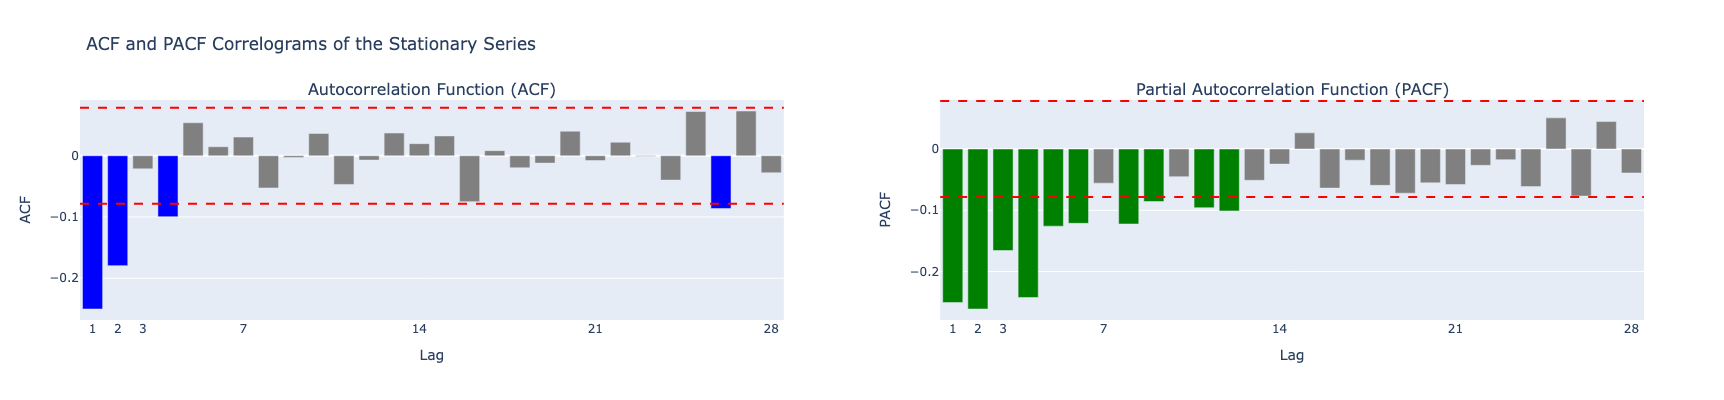

### **ARIMA and SARIMA**

In [ ]:
# Model Parameters
p, d, q = 3, 1, 2
P, D, Q = 1, 0, 0
horizon = m = 7
n_windows = int(len(df_daily_air_quality_bogota_test) / horizon)

In [ ]:
models = [
    ARIMA(order=(p, d, q), season_length=1, alias='ARIMA'),
    ARIMA(order=(p, d, q), seasonal_order=(P, D, Q), season_length=m, alias='SARIMA')
]

sf_arima_family = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

In [ ]:
def calculate_metrics(df, model_col):
    y_true = df['y']
    y_pred = df[model_col]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    return rmse, mse, mape

### **Cross Validation Train**

In [ ]:
df_cv_arima_family_train = sf_arima_family.cross_validation(
    df=df_daily_air_quality_bogota_train,
    h=horizon,
    step_size=horizon,
    n_windows=n_windows
)
df_cv_arima_family_train

,unique_id,ds,cutoff,y,ARIMA,SARIMA
0,Bogota_PM25,2023-12-11,2023-12-10,23.5,24.975742,25.422807
1,Bogota_PM25,2023-12-12,2023-12-10,29.0,27.887138,28.364230
2,Bogota_PM25,2023-12-13,2023-12-10,28.3,28.783147,28.665561
3,Bogota_PM25,2023-12-14,2023-12-10,19.4,28.954634,29.571018
4,Bogota_PM25,2023-12-15,2023-12-10,15.9,29.074108,29.101752
...,...,...,...,...,...,...
58,Bogota_PM25,2024-02-07,2024-02-04,21.0,28.836617,28.914460
59,Bogota_PM25,2024-02-08,2024-02-04,31.5,29.775328,29.918676
60,Bogota_PM25,2024-02-09,2024-02-04,23.7,29.016366,29.106767
61,Bogota_PM25,2024-02-10,2024-02-04,27.8,29.762656,29.661529


In [ ]:
results_train = {}
for m in ['ARIMA', 'SARIMA']:
    rmse, mse, mape = calculate_metrics(df_cv_arima_family_train, m)
    results_train[m] = {'RMSE': rmse, 'MSE': mse, 'MAPE (%)': mape}

console.print(pd.DataFrame(results_train).T)

fig_cv_train = go.Figure()
fig_cv_train.add_trace(go.Scatter(x=df_cv_arima_family_train['ds'], y=df_cv_arima_family_train['y'], name='Actual (Train)', line=dict(color='green')))
colors = {'ARIMA': 'orange', 'SARIMA': 'red'}
for m in ['ARIMA', 'SARIMA']:
    fig_cv_train.add_trace(go.Scatter(
        x=df_cv_arima_family_train['ds'], y=df_cv_arima_family_train[m],
        name=f'{m} Forecast', line=dict(color=colors[m], dash='dash')
    ))
fig_cv_train.update_layout(title='Stage 1: Internal Cross-Validation Forecasts', template='plotly_white', height=500)
fig_cv_train.show()

RMSE        MSE   MAPE (%)
ARIMA   6.031857  36.383301  17.393953
SARIMA  6.085509  37.033421  17.526384

### **Conclusions:**

- After cross-validating with the training data and evaluating its metrics, we found that ARIMA is slightly better, as its RMSE, MAE, and MAPE are lower.

### **Residual Diagnostics**

In [ ]:
sf_arima_family.fit(df=df_daily_air_quality_bogota_train)

def get_residuals_manually(sf_object, model_alias):
    try:
        models_list = sf_object.fitted_[0]

        for model_obj in models_list:
            if model_obj.alias == model_alias:
                return model_obj.model_.get('residuals', [])

        print(f"Model {model_alias} not found in fitted objects.")
        return []
    except Exception as e:
        print(f"Error extracting residuals: {e}")
        return []

def plot_diagnostics(residuals, model_name):
    if len(residuals) == 0:
        print(f"No residuals found for {model_name}. Skipping plots.")
        return

    # Calculate ACF
    acf_vals = acf(residuals, nlags=20, fft=True)

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Residuals over Time', 'Residuals Distribution', 'Autocorrelation (ACF)', 'Q-Q Plot')
    )

    # Residuals over Time
    fig.add_trace(go.Scatter(y=residuals, name='Residuals', line=dict(color='#1f77b4')), row=1, col=1)
    fig.add_hline(y=0, line_dash="dash", line_color="red", row=1, col=1)

    # Distribution (Histogram)
    fig.add_trace(go.Histogram(x=residuals, name='Dist', marker_color='#2ca02c'), row=1, col=2)

    # ACF Plot
    lags = np.arange(len(acf_vals))
    fig.add_trace(go.Bar(x=lags, y=acf_vals, name='ACF', marker_color='#9467bd'), row=2, col=1)
    conf = 1.96 / np.sqrt(len(residuals)) # 95% Confidence Interval
    fig.add_hrect(y0=-conf, y1=conf, fillcolor="gray", opacity=0.2, row=2, col=1)

    # Q-Q Plot
    qq_osm, qq_osr = stats.probplot(residuals, dist="norm", plot=None)
    fig.add_trace(go.Scatter(x=qq_osm[0], y=qq_osm[1], mode='markers', name='Q-Q', marker_color='#d62728'), row=2, col=2)
    slope, intercept, r = stats.linregress(qq_osm[0], qq_osm[1])[0:3]
    x_line = np.linspace(min(qq_osm[0]), max(qq_osm[0]), 100)
    fig.add_trace(go.Scatter(x=x_line, y=slope*x_line + intercept, mode='lines', name='Normal Line', line=dict(color='black', dash='dash')), row=2, col=2)

    fig.update_layout(title=f'Diagnostic Plots: {model_name}', height=700, showlegend=False, template='plotly_white')
    fig.show()


for m in ['ARIMA', 'SARIMA']:
    res_array = get_residuals_manually(sf_arima_family, m)
    plot_diagnostics(res_array, m)

### **Conclusions**

**ARIMA:**

- Successful Temporal Structure Capture: The autocorrelation plot (ACF) shows that the lags are contained within the confidence interval (shaded area), confirming that the residuals behave as white noise. This indicates that the ARIMA(3, 1, 2) model has effectively extracted all relevant information (trend and autocorrelation) from the historical data.

- Robustness and Lack of Bias: The distribution of residuals (histogram) displays a symmetric bell shape centered at zero, and the residuals over time plot shows constant variance with no obvious patterns. This suggests that the model is stable, unbiased, and suitable for generating reliable forecasts.


**SARIMA:**

- White Noise Validation: The autocorrelation plot (ACF) shows that nearly all lags fall within the confidence interval (shaded area). This confirms that, similar to ARIMA, the residuals behave as white noise, indicating that the SARIMA model also successfully captured the data's temporal structure.

- Stable Behavior: The histogram displays an error distribution centered at zero and reasonably symmetric, while the residuals over time plot reveals no trends. This suggests the model is unbiased, although visually it does not offer a noticeable improvement over the simpler ARIMA model.

### **Validation**

In [ ]:
n_obs_val = len(df_daily_air_quality_bogota_test)
n_windows_val = int(np.ceil(n_obs_val / horizon))

# Execute Walk-Forward Validation covering the Test period
df_cv_test = sf_arima_family.cross_validation(
    df=df_daily_air_quality_bogota_formated_by_models,
    h=horizon,
    step_size=horizon,
    n_windows=n_windows_val,
    level=[95]
)

# Calculate Metrics on Test Set
results_test = {}
for m in ['ARIMA', 'SARIMA']:
    rmse, mse, mape = calculate_metrics(df_cv_test, m)
    results_test[m] = {'RMSE': rmse, 'MSE': mse, 'MAPE (%)': mape}

console.print(pd.DataFrame(results_test).T)

# Visual Comparison (Test)
fig_val = go.Figure()
fig_val.add_trace(go.Scatter(x=df_cv_test['ds'], y=df_cv_test['y'], name='Actual (Validation)', line=dict(color='green', width=2)))

for m in ['ARIMA', 'SARIMA']:
    fig_val.add_trace(go.Scatter(
        x=df_cv_test['ds'], y=df_cv_test[m],
        name=f'{m} (Test)', line=dict(color=colors[m], dash='dash')
    ))

fig_val.update_layout(title='Stage 3: Validation Set Performance (Walk-Forward)', template='plotly_white', height=500)
fig_val.show()

RMSE        MSE   MAPE (%)
ARIMA   8.783985  77.158401  22.965915
SARIMA  8.812136  77.653742  22.923865

### **Conclusions:**

- Regarding the training data, we observed an increase in errors, which is normal.
- We also observed that ARIMA remains a better model due to the lower values ​​in these metrics.

In [ ]:
def hex_to_rgba(hex_color, opacity):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {opacity})'

# We use the last 180 days of 'df_train' so the zoom is appropriate.
history_df = df_cv_arima_family_train.tail(180)
validation_results = df_cv_test

models_to_plot = {
    'ARIMA': '#ff7f0e',  # Orange
    'SARIMA': '#d62728'  # Red
}

fig = go.Figure()

# Training History
fig.add_trace(go.Scatter(
    x=history_df['ds'],
    y=history_df['y'],
    name='Training Data',
    mode='lines',
    line=dict(color='#1f77b4', width=2)
))

# Actual Validation Data
fig.add_trace(go.Scatter(
    x=validation_results['ds'],
    y=validation_results['y'],
    name='Observed (Validation)',
    mode='lines',
    line=dict(color='#2ca02c', width=2)
))

# Loop to Plot Models (Forecast + Confidence Intervals)
for model_name, color in models_to_plot.items():

    col_mean = model_name
    col_lo = f'{model_name}-lo-95'
    col_hi = f'{model_name}-hi-95'

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_hi],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_lo],
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=hex_to_rgba(color, 0.2),
        name=f'{model_name} (95% IC)'
    ))

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_mean],
        name=f'{model_name} (Forecast)',
        mode='lines',
        line=dict(color=color, dash='dash', width=2)
    ))

fig.update_layout(
    title='Forecast Comparison - Validation Data',
    xaxis_title='Date',
    yaxis_title='PM2.5 Concentration',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

### **Future Forecasts - Best Model**

In [ ]:
best_arima_family_model = 'ARIMA'
final_arima_family_models = [ARIMA(order=(p, d, q), season_length=1, alias='ARIMA')]

sf_arima_family_final = StatsForecast(
    models=final_arima_family_models,
    freq='D',
    n_jobs=-1)

sf_arima_family_final.fit(df=df_daily_air_quality_bogota_formated_by_models)


df_future = sf_arima_family_final.forecast(
    df=df_daily_air_quality_bogota_formated_by_models,
    h=horizon,
    level=[95])
console.print(df_future.head())


fig_future = go.Figure()
# History (Last 30 days for context)
fig_future.add_trace(go.Scatter(
    x=df_daily_air_quality_bogota_formated_by_models['ds'].tail(30),
    y=df_daily_air_quality_bogota_formated_by_models['y'].tail(30),
    name='History',
    line=dict(color='gray')
))

# Future Forecast
fig_future.add_trace(go.Scatter(
    x=df_future['ds'],
    y=df_future[best_arima_family_model],
    name=f'Future {best_arima_family_model}',
    line=dict(color='#1f77b4', width=2)
))

# Confidence Intervals
col_hi = f'{best_arima_family_model}-hi-95'
col_lo = f'{best_arima_family_model}-lo-95'

fig_future.add_trace(go.Scatter(
    x=df_future['ds'], y=df_future[col_hi],
    mode='lines', line_color='rgba(0,0,0,0)', showlegend=False
))
fig_future.add_trace(go.Scatter(
    x=df_future['ds'], y=df_future[col_lo],
    mode='lines', line_color='rgba(0,0,0,0)', fill='tonexty',
    fillcolor='rgba(31, 119, 180, 0.2)', name='95% Interval'
))

fig_future.update_layout(title=f'Stage 4: Future Forecast (Next {horizon} Days)', template='plotly_white', height=500)
fig_future.show()

unique_id         ds      ARIMA  ARIMA-lo-95  ARIMA-hi-95
0  Bogota_PM25 2024-04-21  28.089490    17.230500    38.948481
1  Bogota_PM25 2024-04-22  31.726768    19.637089    43.816448
2  Bogota_PM25 2024-04-23  33.665396    21.379689    45.951103
3  Bogota_PM25 2024-04-24  33.710026    21.303205    46.116848
4  Bogota_PM25 2024-04-25  34.288992    21.842668    46.735317

### Conclusions

**Predictive Performance:** Both models successfully captured the temporal structure of the data, resulting in residuals that resemble white noise. However, the non-seasonal **ARIMA(3, 1, 2)** achieved slightly superior accuracy, recording lower RMSE and MAPE values than the SARIMA model during the walk-forward validation.

### Final Verdict

The **ARIMA(3, 1, 2)** model is the optimal choice for production. It adheres to the principle of parsimony, delivering better predictive results and statistical efficiency without the unnecessary complexity of an explicit seasonal component.

## **2. EXPONENTIAL SMOOTHING**

In [ ]:
models_smoothing = [
    Holt(alias='Holt'),
    HoltWinters(season_length=7, alias='HoltWinters')
]

sf_smoothing = StatsForecast(
    models=models_smoothing,
    freq='D',
    n_jobs=-1
)

### **Cross Validation Train**

In [ ]:
df_cv_smoothing_train = sf_smoothing.cross_validation(
    df=df_daily_air_quality_bogota_train,
    h=horizon,
    step_size=horizon,
    n_windows=n_windows
)

df_cv_smoothing_train

,unique_id,ds,cutoff,y,Holt,HoltWinters
0,Bogota_PM25,2023-12-11,2023-12-10,23.5,29.509739,29.101687
1,Bogota_PM25,2023-12-12,2023-12-10,29.0,29.544422,28.644280
2,Bogota_PM25,2023-12-13,2023-12-10,28.3,29.579105,29.297865
3,Bogota_PM25,2023-12-14,2023-12-10,19.4,29.613788,29.269526
4,Bogota_PM25,2023-12-15,2023-12-10,15.9,29.648471,29.506451
...,...,...,...,...,...,...
58,Bogota_PM25,2024-02-07,2024-02-04,21.0,29.685389,29.108006
59,Bogota_PM25,2024-02-08,2024-02-04,31.5,29.716660,29.270710
60,Bogota_PM25,2024-02-09,2024-02-04,23.7,29.747932,29.667276
61,Bogota_PM25,2024-02-10,2024-02-04,27.8,29.779204,30.474799


In [ ]:
results_train = {}
for m in ['Holt', 'HoltWinters']:
    rmse, mse, mape = calculate_metrics(df_cv_smoothing_train, m)
    results_train[m] = {'RMSE': rmse, 'MSE': mse, 'MAPE (%)': mape}

console.print(pd.DataFrame(results_train).T)

fig_cv_train = go.Figure()
fig_cv_train.add_trace(go.Scatter(x=df_cv_smoothing_train['ds'], y=df_cv_smoothing_train['y'], name='Actual (Train)', line=dict(color='green')))
colors = {'Holt': 'orange', 'HoltWinters': 'red'}
for m in ['Holt', 'HoltWinters']:
    fig_cv_train.add_trace(go.Scatter(
        x=df_cv_smoothing_train['ds'], y=df_cv_smoothing_train[m],
        name=f'{m} Forecast', line=dict(color=colors[m], dash='dash')
    ))
fig_cv_train.update_layout(title='Stage 1: Internal Cross-Validation Forecasts', template='plotly_white', height=500)
fig_cv_train.show()

RMSE        MSE   MAPE (%)
Holt         6.592260  43.457886  19.166608
HoltWinters  6.598436  43.539351  19.153981

### **Residual Diagnostics**

In [ ]:
sf_smoothing.fit(df=df_daily_air_quality_bogota_train)

for m in ['Holt', 'HoltWinters']:
    res_array = get_residuals_manually(sf_smoothing, m)
    plot_diagnostics(res_array, m)

### **Conclusions**

- We observed that the Hotl and HotWinters models exhibit a high zero-centered distribution, but with greater data dispersion than those of ARIMA and SARIMA.

- Furthermore, the autocorrelation sometimes exceeds the confidence intervals, compared to ARIMA and SARIMA, where it never did and the intervals were smaller.

This also demonstrates that the models are stable.

### **Validation**

In [ ]:
n_obs_val = len(df_daily_air_quality_bogota_test)
n_windows_val = int(np.ceil(n_obs_val / horizon))

# Execute Walk-Forward Validation covering the Test period
df_cv_smoothing_test = sf_smoothing.cross_validation(
    df=df_daily_air_quality_bogota_formated_by_models,
    h=horizon,
    step_size=horizon,
    n_windows=n_windows_val,
    level=[95]
)

# Calculate Metrics on Test Set
results_test = {}
for m in ['Holt', 'HoltWinters']:
    rmse, mse, mape = calculate_metrics(df_cv_smoothing_test, m)
    results_test[m] = {'RMSE': rmse, 'MSE': mse, 'MAPE (%)': mape}

console.print(pd.DataFrame(results_test).T)

# Visual Comparison (Test)
fig_val = go.Figure()
fig_val.add_trace(go.Scatter(x=df_cv_smoothing_test['ds'], y=df_cv_smoothing_test['y'], name='Actual (Validation)', line=dict(color='green', width=2)))

for m in ['Holt', 'HoltWinters']:
    fig_val.add_trace(go.Scatter(
        x=df_cv_smoothing_test['ds'], y=df_cv_smoothing_test[m],
        name=f'{m} (Test)', line=dict(color=colors[m], dash='dash')
    ))

fig_val.update_layout(title='Stage 3: Validation Set Performance (Walk-Forward)', template='plotly_white', height=500)
fig_val.show()

RMSE        MSE   MAPE (%)
Holt         9.625660  92.653334  24.957519
HoltWinters  9.652212  93.165189  24.957839

In [ ]:
def hex_to_rgba(hex_color, opacity):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {opacity})'

# We use the last 180 days of 'df_train' so the zoom is appropriate.
history_df = df_cv_smoothing_train.tail(180)
validation_results = df_cv_smoothing_test

models_to_plot = {
    'Holt': '#ff7f0e',  # Orange
    'HoltWinters': '#d62728'  # Red
}

fig = go.Figure()

# Training History
fig.add_trace(go.Scatter(
    x=history_df['ds'],
    y=history_df['y'],
    name='Training Data',
    mode='lines',
    line=dict(color='#1f77b4', width=2)
))

# Actual Validation Data
fig.add_trace(go.Scatter(
    x=validation_results['ds'],
    y=validation_results['y'],
    name='Observed (Validation)',
    mode='lines',
    line=dict(color='#2ca02c', width=2)
))

# Loop to Plot Models (Forecast + Confidence Intervals)
for model_name, color in models_to_plot.items():

    col_mean = model_name
    col_lo = f'{model_name}-lo-95'
    col_hi = f'{model_name}-hi-95'

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_hi],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_lo],
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=hex_to_rgba(color, 0.2),
        name=f'{model_name} (95% IC)'
    ))

    fig.add_trace(go.Scatter(
        x=validation_results['ds'],
        y=validation_results[col_mean],
        name=f'{model_name} (Forecast)',
        mode='lines',
        line=dict(color=color, dash='dash', width=2)
    ))

fig.update_layout(
    title='Forecast Comparison - Validation Data',
    xaxis_title='Date',
    yaxis_title='PM2.5 Concentration',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

### **Future Forecasts - Best Model**

In [ ]:
best_smoothing_family_model = 'Holt'
final_smoothing_family_models = [Holt(alias='Holt'),]

sf_smoothing_final = StatsForecast(
    models=final_smoothing_family_models,
    freq='D',
    n_jobs=-1)

sf_smoothing_final.fit(df=df_daily_air_quality_bogota_formated_by_models)


df_future = sf_smoothing_final.forecast(
    df=df_daily_air_quality_bogota_formated_by_models,
    h=horizon,
    level=[95])

console.print(df_future.head())


fig_future = go.Figure()
# History (Last 30 days for context)
fig_future.add_trace(go.Scatter(
    x=df_daily_air_quality_bogota_formated_by_models['ds'].tail(30),
    y=df_daily_air_quality_bogota_formated_by_models['y'].tail(30),
    name='History',
    line=dict(color='gray')
))

# Future Forecast
fig_future.add_trace(go.Scatter(
    x=df_future['ds'],
    y=df_future[best_smoothing_family_model],
    name=f'Future {best_smoothing_family_model}',
    line=dict(color='#1f77b4', width=2)
))

# Confidence Intervals
col_hi = f'{best_smoothing_family_model}-hi-95'
col_lo = f'{best_smoothing_family_model}-lo-95'

fig_future.add_trace(go.Scatter(
    x=df_future['ds'], y=df_future[col_hi],
    mode='lines', line_color='rgba(0,0,0,0)', showlegend=False
))
fig_future.add_trace(go.Scatter(
    x=df_future['ds'], y=df_future[col_lo],
    mode='lines', line_color='rgba(0,0,0,0)', fill='tonexty',
    fillcolor='rgba(31, 119, 180, 0.2)', name='95% Interval'
))

fig_future.update_layout(title=f'Stage 4: Future Forecast (Next {horizon} Days)', template='plotly_white', height=500)
fig_future.show()

unique_id         ds       Holt  Holt-lo-95  Holt-hi-95
0  Bogota_PM25 2024-04-21  30.852203   19.281256   42.423151
1  Bogota_PM25 2024-04-22  30.880422   18.840456   42.920389
2  Bogota_PM25 2024-04-23  30.908641   18.416945   43.400338
3  Bogota_PM25 2024-04-24  30.936861   18.008912   43.864809
4  Bogota_PM25 2024-04-25  30.965080   17.614838   44.315321

**Holt vs. Holt-Winters** comparison:

1.  **Trend Dominance:** The **Holt** model (Double Smoothing) is sufficient for this dataset, proving that capturing the recent **trend** is far more critical for accuracy than modeling the weekly cycle found in Holt-Winters.

2.  **Parsimony Wins:** Since both models yield statistically identical error metrics, **Holt** is the superior choice for production. It achieves the same predictive power with **less complexity** and fewer parameters than Holt-Winters.

## **Machine Learning Models**

**Feature Engineering**

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

### **Optimization Loop**

In [ ]:
model_names = ['lasso', 'ridge', 'knn', 'rf', 'xgb', 'lgb']
tuning_results = {}

In [ ]:
def get_model(name, p):

    if name == 'lasso':
        return Lasso(alpha=p['alpha'], random_state=42)

    elif name == 'ridge':
        return Ridge(alpha=p['alpha'], random_state=42)

    elif name == 'knn':
        return KNeighborsRegressor(n_neighbors=p['n_neighbors'], weights=p['weights'], p=p['p'])

    elif name == 'rf':
        return RandomForestRegressor(n_estimators=p['n_estimators'],
                                     max_depth=p['max_depth'],
                                     min_samples_split=p['min_samples_split'],
                                     min_samples_leaf=p['min_samples_leaf'],
                                     random_state=42,
                                     n_jobs=-1)

    elif name == 'xgb':
        return xgb.XGBRegressor(n_estimators=p['n_estimators'],
                                learning_rate=p['learning_rate'],
                                max_depth=p['max_depth'],
                                objective=p['objective'],
                                reg_alpha=p['reg_alpha'],
                                reg_lambda=p['reg_lambda'],
                                random_state=42,
                                n_jobs=-1)

    elif name == 'lgb':
        return lgb.LGBMRegressor(n_estimators=p['n_estimators'],
                                 learning_rate=p['learning_rate'],
                                 num_leaves=p['num_leaves'],
                                 objective=p["objective"],
                                 reg_alpha=p['reg_alpha'],
                                 reg_lambda=p['reg_lambda'],
                                 random_state=42,
                                 n_jobs=-1)
    return None

### **Lag Selection:**

⁠lags=[1, 2, 3, 7, 14]: The selected lags allow us to capture short-, medium-, and long-term temporal relationships:

Lag 1, 2, and 3 → immediate effect and effects from previous days. Furthermore, our graphs about autocorrelation shows these lags

Lag 7 → behavior from one week ago.

Lag 14 and 21 → longer weekly cycles and approximate monthly repetitions.

This allows models to detect short-term memory patterns and approximate weekly/monthly seasonality without the need for more complex transformations.

### **Date_features**

date_features=['month', 'dayofweek']: Dates provide valuable information:

month: Monthly seasonal patterns (weather, precipitation, winds).
dayofweek: Clear differences in pollution levels between weekdays and weekends.


In [ ]:
import traceback
import logging
import sys

optuna.logging.set_verbosity(optuna.logging.DEBUG) # O usa INFO para menos ruido
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

console.print("Hyperparameter Tuning (Internal CV)")

for name in model_names:
    print(f"   -> Optimizing {name.upper()}...")

    def objective(trial):
        # --- UPDATED HYPERPARAMETERS ---
        if name == 'lasso':
            params = {'alpha': trial.suggest_float('alpha', 1e-4, 10.0, log=True)}

        elif name == 'ridge':
            params = {'alpha': trial.suggest_float('alpha', 1e-4, 10.0, log=True)}

        elif name == 'knn':
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 3, 30),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'p': trial.suggest_int('p', 1, 2) # 1=Manhattan, 2=Euclidean
            }

        elif name == 'rf':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10) # Important for overfitting
            }

        elif name == 'xgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
                'max_depth': trial.suggest_int('max_depth', 1, 10),
                'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:pseudohubererror']),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
            }

        elif name == 'lgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 2, 128, log=True),
                'objective': trial.suggest_categorical('objective', ['l1', 'l2']),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
            }

        model = get_model(name, params)

        # MLForecast Setup
        fcst = MLForecast(
            models=[model], freq='D',
            lags=[1, 2, 3, 7, 14],
            lag_transforms={1: [(rolling_mean, 7), (rolling_std, 7)]},
            date_features=['dayofweek', 'month'],
            target_transforms=[Differences([1])]
        )

        try:
            # Internal CV on Training Data
            cv_res = fcst.cross_validation(
                df=df_daily_air_quality_bogota_train,
                h=horizon,
                step_size=horizon,
                n_windows=n_windows)

            return np.sqrt(mean_squared_error(cv_res['y'], cv_res.iloc[:, -1]))
        except Exception as e:
            console.print(f"\nERROR FATAL en Trial {trial.number}:")
            console.print(f"Modelo: {name}")
            console.print(f"Error: {str(e)}")
            console.print("Traceback completo:")
            traceback.print_exc()
            console.print("-" * 30)
            return float('inf')

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=40)

    tuning_results[name] = {
        'best_params': study.best_params,
        'train_rmse': study.best_value
    }

Hyperparameter Tuning (Internal CV)

[I 2025-11-26 00:15:31,691] A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673


   -> Optimizing LASSO...
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673
A new study created in memory with name: no-name-ba555ca5-7864-404e-9a25-5b1b6726c673


[I 2025-11-26 00:15:33,848] Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.


Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 0 finished with value: 6.644323485611461 and parameters: {'alpha': 0.47050284069734044}. Best is trial 0 with value: 6.644323485611461.
Trial 

[I 2025-11-26 00:15:35,742] Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.


Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.
Trial 1 finished with value: 6.868614104301001 and parameters: {'alpha': 0.028082343246785907}. Best is trial 0 with value: 6.644323485611461.

[I 2025-11-26 00:15:36,944] Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.


Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.
Trial 2 finished with value: 6.873701010077236 and parameters: {'alpha': 0.014616357542249785}. Best is trial 0 with value: 6.644323485611461.

[I 2025-11-26 00:15:40,121] Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.


Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.
Trial 3 finished with value: 6.871721099882964 and parameters: {'alpha': 0.019819522537732767}. Best is trial 0 with value: 6.644323485611461.

[I 2025-11-26 00:15:41,213] Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.


Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.
Trial 4 finished with value: 6.879015122048904 and parameters: {'alpha': 0.000767982173995351}. Best is trial 0 with value: 6.644323485611461.

[I 2025-11-26 00:15:41,864] Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.


Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.
Trial 5 finished with value: 6.877097669185073 and parameters: {'alpha': 0.005739938099548885}. Best is trial 0 with value: 6.644323485611461.

[I 2025-11-26 00:15:42,529] Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.


Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 6 finished with value: 6.868245024542199 and parameters: {'alpha': 0.02907306239442797}. Best is trial 0 with value: 6.644323485611461.
Trial 

[I 2025-11-26 00:15:43,171] Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.


Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished with value: 6.573485371755407 and parameters: {'alpha': 5.088680299423794}. Best is trial 7 with value: 6.573485371755407.
Trial 7 finished wit

[I 2025-11-26 00:15:43,978] Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.


Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished with value: 6.506247911977692 and parameters: {'alpha': 3.166843584282883}. Best is trial 8 with value: 6.506247911977692.
Trial 8 finished wit

[I 2025-11-26 00:15:44,645] Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.


Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911977692.
Trial 9 finished with value: 6.878663285596212 and parameters: {'alpha': 0.0016775892971758104}. Best is trial 8 with value: 6.506247911

[I 2025-11-26 00:15:45,270] Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.


Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 finished with value: 6.654524590297333 and parameters: {'alpha': 7.603523085301493}. Best is trial 8 with value: 6.506247911977692.
Trial 10 fini

[I 2025-11-26 00:15:45,911] Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.


Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 finished with value: 6.604925027744209 and parameters: {'alpha': 6.081206121650018}. Best is trial 8 with value: 6.506247911977692.
Trial 11 fini

[I 2025-11-26 00:15:46,560] Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.


Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 12 finished with value: 6.618063492830286 and parameters: {'alpha': 0.5250751398350029}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:47,209] Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.


Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 13 finished with value: 6.647024265658316 and parameters: {'alpha': 0.4650743933349105}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:47,886] Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.


Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 14 finished with value: 6.529878997059619 and parameters: {'alpha': 1.3709297480191502}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:48,573] Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.


Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with value: 6.506247911977692.
Trial 15 finished with value: 6.879267410943045 and parameters: {'alpha': 0.00011549465586026805}. Best is trial 8 with valu

[I 2025-11-26 00:15:49,251] Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.


Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 16 finished with value: 6.525664016860511 and parameters: {'alpha': 1.5114412529338686}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:49,922] Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.


Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.
Trial 17 finished with value: 6.837174482179428 and parameters: {'alpha': 0.10857184383113382}. Best is trial 8 with value: 6.506247911977692.

[I 2025-11-26 00:15:50,600] Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.


Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.
Trial 18 finished with value: 6.829501954748342 and parameters: {'alpha': 0.12336612619681936}. Best is trial 8 with value: 6.506247911977692.

[I 2025-11-26 00:15:51,481] Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.


Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 finished with value: 6.51259193163521 and parameters: {'alpha': 1.9712558701596983}. Best is trial 8 with value: 6.506247911977692.
Trial 19 fini

[I 2025-11-26 00:15:52,553] Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.


Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 20 finished with value: 6.83309308075176 and parameters: {'alpha': 0.11642483818816517}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:53,554] Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.


Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 21 finished with value: 6.515029961617377 and parameters: {'alpha': 1.8954796079078637}. Best is trial 8 with value: 6.506247911977692.
Trial 

[I 2025-11-26 00:15:54,615] Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.


Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished with value: 6.51029712825123 and parameters: {'alpha': 2.047337276188204}. Best is trial 8 with value: 6.506247911977692.
Trial 22 finished wi

[I 2025-11-26 00:15:55,760] Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.


Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 23 finished with value: 6.502649787955984 and parameters: {'alpha': 2.426199240319613}. Best is trial 23 with value: 6.502649787955984.
Trial 

[I 2025-11-26 00:15:56,880] Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.


Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.
Trial 24 finished with value: 6.765169067774697 and parameters: {'alpha': 0.2561655509537558}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:15:57,536] Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.


Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.
Trial 25 finished with value: 6.507504261965636 and parameters: {'alpha': 3.2255492097174354}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:15:58,160] Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.


Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 26 finished with value: 6.677795757928262 and parameters: {'alpha': 8.997752787637213}. Best is trial 23 with value: 6.502649787955984.
Trial 

[I 2025-11-26 00:15:58,825] Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.


Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.
Trial 27 finished with value: 6.514500986655227 and parameters: {'alpha': 3.4703264936296314}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:15:59,465] Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.


Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.
Trial 28 finished with value: 6.518728316096828 and parameters: {'alpha': 0.8107817331594954}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:16:00,107] Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.


Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787955984.
Trial 29 finished with value: 6.765835353443367 and parameters: {'alpha': 0.25461283200935686}. Best is trial 23 with value: 6.502649787

[I 2025-11-26 00:16:00,807] Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.


Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 30 finished with value: 6.517617225439336 and parameters: {'alpha': 3.554935967624052}. Best is trial 23 with value: 6.502649787955984.
Trial 

[I 2025-11-26 00:16:01,517] Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.


Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 31 finished with value: 6.530470131576498 and parameters: {'alpha': 0.761635449735752}. Best is trial 23 with value: 6.502649787955984.
Trial 

[I 2025-11-26 00:16:02,191] Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.


Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.
Trial 32 finished with value: 6.503318752070332 and parameters: {'alpha': 2.9847075036426594}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:16:02,850] Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.


Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.
Trial 33 finished with value: 6.5111997066895375 and parameters: {'alpha': 3.367278301758069}. Best is trial 23 with value: 6.502649787955984.

[I 2025-11-26 00:16:03,510] Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.


Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787955984.
Trial 34 finished with value: 6.7636731902784275 and parameters: {'alpha': 0.2596612893513286}. Best is trial 23 with value: 6.502649787

[I 2025-11-26 00:16:04,180] Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.


Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 finished with value: 6.50125320197215 and parameters: {'alpha': 0.9926565654786528}. Best is trial 35 with value: 6.50125320197215.
Trial 35 fini

[I 2025-11-26 00:16:04,846] Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.


Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 finished with value: 6.698040532981506 and parameters: {'alpha': 9.978941425697974}. Best is trial 35 with value: 6.50125320197215.
Trial 36 fini

[I 2025-11-26 00:16:05,489] Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.


Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.
Trial 37 finished with value: 6.500919140864257 and parameters: {'alpha': 0.9735780070594997}. Best is trial 37 with value: 6.500919140864257.

[I 2025-11-26 00:16:06,386] Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.


Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140864257.
Trial 38 finished with value: 6.862187943117937 and parameters: {'alpha': 0.04544250745380051}. Best is trial 37 with value: 6.500919140

[I 2025-11-26 00:16:07,288] Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.


Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.
Trial 39 finished with value: 6.503620360611828 and parameters: {'alpha': 0.9105789223184013}. Best is trial 37 with value: 6.500919140864257.

[I 2025-11-26 00:16:07,296] A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2


   -> Optimizing RIDGE...
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2
A new study created in memory with name: no-name-79543240-dcb0-4f16-83f8-f6e11b2746b2


[I 2025-11-26 00:16:08,274] Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.


Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364759623.
Trial 0 finished with value: 6.879310364759623 and parameters: {'alpha': 0.0006478189014612403}. Best is trial 0 with value: 6.879310364

[I 2025-11-26 00:16:09,057] Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.


Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finished with value: 6.878889639596136 and parameters: {'alpha': 0.1555073165713897}. Best is trial 1 with value: 6.878889639596136.
Trial 1 finis

[I 2025-11-26 00:16:09,693] Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.


Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 2 finished with value: 6.878393981926528 and parameters: {'alpha': 0.33821372215980056}. Best is trial 2 with value: 6.878393981926528.
Trial 

[I 2025-11-26 00:16:10,338] Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.


Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.
Trial 3 finished with value: 6.8679613830319814 and parameters: {'alpha': 4.2519832987143005}. Best is trial 3 with value: 6.8679613830319814.

[I 2025-11-26 00:16:10,966] Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.


Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 4 finished with value: 6.874971610402761 and parameters: {'alpha': 1.6076615882569822}. Best is trial 3 with value: 6.8679613830319814.
Trial 

[I 2025-11-26 00:16:11,615] Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.


Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.8679613830319814.
Trial 5 finished with value: 6.8793031640519064 and parameters: {'alpha': 0.003296497458897288}. Best is trial 3 with value: 6.867

[I 2025-11-26 00:16:12,267] Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.


Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.
Trial 6 finished with value: 6.879226622059809 and parameters: {'alpha': 0.03145513168341548}. Best is trial 3 with value: 6.8679613830319814.

[I 2025-11-26 00:16:12,896] Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.


Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.
Trial 7 finished with value: 6.8768883686316045 and parameters: {'alpha': 0.8949759938573731}. Best is trial 3 with value: 6.8679613830319814.

[I 2025-11-26 00:16:13,567] Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.


Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value: 6.8679613830319814.
Trial 8 finished with value: 6.879311821699517 and parameters: {'alpha': 0.00011191152102963059}. Best is trial 3 with value

[I 2025-11-26 00:16:14,177] Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.


Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830319814.
Trial 9 finished with value: 6.879300749552498 and parameters: {'alpha': 0.004184650497847524}. Best is trial 3 with value: 6.8679613830

[I 2025-11-26 00:16:14,815] Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.


Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.
Trial 10 finished with value: 6.8690573825388315 and parameters: {'alpha': 3.834590591207456}. Best is trial 3 with value: 6.8679613830319814.

[I 2025-11-26 00:16:15,454] Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.


Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 11 finished with value: 6.856013968351191 and parameters: {'alpha': 8.900913609100714}. Best is trial 11 with value: 6.856013968351191.
Trial 

[I 2025-11-26 00:16:16,073] Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.


Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 12 finished with value: 6.861076691177707 and parameters: {'alpha': 6.908456017904673}. Best is trial 11 with value: 6.856013968351191.
Trial 

[I 2025-11-26 00:16:16,735] Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.


Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 13 finished with value: 6.853804777893639 and parameters: {'alpha': 9.780991553936072}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:17,446] Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.


Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777893639.
Trial 14 finished with value: 6.879055218146418 and parameters: {'alpha': 0.09453686058779416}. Best is trial 13 with value: 6.853804777

[I 2025-11-26 00:16:18,086] Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.


Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 15 finished with value: 6.856064928510231 and parameters: {'alpha': 8.880689575730797}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:18,874] Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.


Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.
Trial 16 finished with value: 6.876551657954627 and parameters: {'alpha': 1.0198549519376727}. Best is trial 13 with value: 6.853804777893639.

[I 2025-11-26 00:16:19,825] Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.


Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.853804777893639.
Trial 17 finished with value: 6.879158996613665 and parameters: {'alpha': 0.056339200995651366}. Best is trial 13 with value: 6.85

[I 2025-11-26 00:16:20,757] Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.


Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.853804777893639.
Trial 18 finished with value: 6.879265512354227 and parameters: {'alpha': 0.017147128693112957}. Best is trial 13 with value: 6.85

[I 2025-11-26 00:16:21,662] Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.


Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777893639.
Trial 19 finished with value: 6.878274386140825 and parameters: {'alpha': 0.38234157747799313}. Best is trial 13 with value: 6.853804777

[I 2025-11-26 00:16:22,299] Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.


Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.
Trial 20 finished with value: 6.873365545685541 and parameters: {'alpha': 2.2082082106565943}. Best is trial 13 with value: 6.853804777893639.

[I 2025-11-26 00:16:22,949] Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.


Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 finished with value: 6.85553347800586 and parameters: {'alpha': 9.091771069213367}. Best is trial 13 with value: 6.853804777893639.
Trial 21 fini

[I 2025-11-26 00:16:23,564] Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.


Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 22 finished with value: 6.858513078971834 and parameters: {'alpha': 7.913172009999403}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:24,200] Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.


Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.
Trial 23 finished with value: 6.877497219855715 and parameters: {'alpha': 0.6695063689733715}. Best is trial 13 with value: 6.853804777893639.

[I 2025-11-26 00:16:24,843] Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.


Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777893639.
Trial 24 finished with value: 6.8721595417759564 and parameters: {'alpha': 2.6612076777895175}. Best is trial 13 with value: 6.853804777

[I 2025-11-26 00:16:25,468] Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.


Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 25 finished with value: 6.857603825034685 and parameters: {'alpha': 8.271587844199123}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:26,092] Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.


Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 26 finished with value: 6.878499841605477 and parameters: {'alpha': 0.299168156839241}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:26,715] Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.


Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 27 finished with value: 6.872703681118785 and parameters: {'alpha': 2.456599817271873}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:27,363] Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.


Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777893639.
Trial 28 finished with value: 6.8759897302167685 and parameters: {'alpha': 1.2285617752117481}. Best is trial 13 with value: 6.853804777

[I 2025-11-26 00:16:28,014] Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.


Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 with value: 6.853804777893639.
Trial 29 finished with value: 6.8793113823229595 and parameters: {'alpha': 0.0002735274949545621}. Best is trial 13 wi

[I 2025-11-26 00:16:28,675] Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.


Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.853804777893639.
Trial 30 finished with value: 6.87930745492932 and parameters: {'alpha': 0.0017181515570162584}. Best is trial 13 with value: 6.85

[I 2025-11-26 00:16:29,339] Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.


Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 31 finished with value: 6.855283042260477 and parameters: {'alpha': 9.191369832077573}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:29,983] Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.


Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 32 finished with value: 6.867065929355311 and parameters: {'alpha': 4.594110421760359}. Best is trial 13 with value: 6.853804777893639.
Trial 

[I 2025-11-26 00:16:30,632] Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.


Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597860185.
Trial 33 finished with value: 6.8537376597860185 and parameters: {'alpha': 9.807832116619775}. Best is trial 33 with value: 6.8537376597

[I 2025-11-26 00:16:31,307] Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.


Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597860185.
Trial 34 finished with value: 6.869233117850579 and parameters: {'alpha': 3.7678032040571985}. Best is trial 33 with value: 6.8537376597

[I 2025-11-26 00:16:32,286] Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.


Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.8537376597860185.
Trial 35 finished with value: 6.878095479287156 and parameters: {'alpha': 0.44838510627982114}. Best is trial 33 with value: 6.853

[I 2025-11-26 00:16:33,178] Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.


Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.8537376597860185.
Trial 36 finished with value: 6.878866090298963 and parameters: {'alpha': 0.16418140497788142}. Best is trial 33 with value: 6.853

[I 2025-11-26 00:16:34,153] Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.


Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597860185.
Trial 37 finished with value: 6.874851020244068 and parameters: {'alpha': 1.6526456819954176}. Best is trial 33 with value: 6.8537376597

[I 2025-11-26 00:16:34,868] Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.


Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.
Trial 38 finished with value: 6.867994430214597 and parameters: {'alpha': 4.239376038051877}. Best is trial 33 with value: 6.8537376597860185.

[I 2025-11-26 00:16:35,570] Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.


Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value: 6.8537376597860185.
Trial 39 finished with value: 6.879274525064597 and parameters: {'alpha': 0.013831543674061583}. Best is trial 33 with value

[I 2025-11-26 00:16:35,586] A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86


   -> Optimizing KNN...
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86
A new study created in memory with name: no-name-fead077a-3c8a-4c30-a9c2-1602ee420d86


[I 2025-11-26 00:16:36,317] Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.


Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.06285203428991 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 0 finished with value: 7.062852034

[I 2025-11-26 00:16:37,034] Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.


Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 7.06285203428991.
Trial 1 finished with value: 7.117187659482227

[I 2025-11-26 00:16:37,729] Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.


Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697709707 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 2 finished with value: 7.594599697

[I 2025-11-26 00:16:38,421] Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.


Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830533499 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 3 finished with value: 7.109832830

[I 2025-11-26 00:16:39,163] Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.


Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664742811 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 4 finished with value: 7.626189664

[I 2025-11-26 00:16:39,856] Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.


Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508567695412735 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 7.06285203428991.
Trial 5 finished with value: 7.508

[I 2025-11-26 00:16:40,529] Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.


Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960342196477376 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 6 finished with value: 6.960

[I 2025-11-26 00:16:41,211] Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.


Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189298021715661 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 6.960342196477376.
Trial 7 finished with value: 8.189

[I 2025-11-26 00:16:41,907] Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.


Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 8 finished with value:

[I 2025-11-26 00:16:42,589] Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.


Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.24722305436238 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 6.944864814166423.
Trial 9 finished with value: 7.247223054

[I 2025-11-26 00:16:43,336] Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.


Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 6.856006227436786.
Trial 10 finishe

[I 2025-11-26 00:16:44,029] Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finished with value: 6.817349877664011 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 11 finishe

[I 2025-11-26 00:16:44,911] Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 12 finishe

[I 2025-11-26 00:16:45,827] Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finished with value: 6.944864814166423 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 13 finishe

[I 2025-11-26 00:16:46,814] Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 finished with value: 6.9212750858527325 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 14 f

[I 2025-11-26 00:16:47,681] Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finished with value: 7.155933148672832 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 15 finishe

[I 2025-11-26 00:16:48,389] Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finished with value: 7.183378221098619 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 16 finishe

[I 2025-11-26 00:16:49,090] Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 17 finishe

[I 2025-11-26 00:16:49,792] Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with value: 7.079819463172515 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 18 finished with

[I 2025-11-26 00:16:50,492] Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 19 finishe

[I 2025-11-26 00:16:51,204] Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finished with value: 7.017258418362605 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 20 finishe

[I 2025-11-26 00:16:51,906] Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finished with value: 6.856006227436786 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 21 finishe

[I 2025-11-26 00:16:52,599] Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 22 finishe

[I 2025-11-26 00:16:53,299] Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 23 finishe

[I 2025-11-26 00:16:53,986] Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 24 finishe

[I 2025-11-26 00:16:54,702] Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 25 finishe

[I 2025-11-26 00:16:55,381] Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value: 7.03052265550178 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 26 finished with value

[I 2025-11-26 00:16:56,084] Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 27 finishe

[I 2025-11-26 00:16:56,787] Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finished with value: 6.953886491948423 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 28 finishe

[I 2025-11-26 00:16:57,602] Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 finished with value: 7.2278313949847055 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 29 f

[I 2025-11-26 00:16:58,588] Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with value: 6.85285555571279 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 30 finished with

[I 2025-11-26 00:16:59,606] Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finished with value: 6.827328919242727 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 31 finishe

[I 2025-11-26 00:17:00,546] Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 32 finishe

[I 2025-11-26 00:17:01,244] Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finished with value: 7.019910941038972 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 33 finishe

[I 2025-11-26 00:17:01,985] Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 34 finished with

[I 2025-11-26 00:17:02,671] Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finished with value: 6.885194289815023 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 35 finishe

[I 2025-11-26 00:17:03,367] Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.


Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with value: 7.182115560818169 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 36 finished with

[I 2025-11-26 00:17:04,078] Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finished with value: 7.009110791854558 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 37 finishe

[I 2025-11-26 00:17:04,758] Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.


Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finished with value: 7.095124236003092 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 6.817349877664011.
Trial 38 finishe

[I 2025-11-26 00:17:05,451] Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.


Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with value: 6.871449218385654 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 11 with value: 6.817349877664011.
Trial 39 finished with

[I 2025-11-26 00:17:05,464] A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595


   -> Optimizing RF...
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595
A new study created in memory with name: no-name-2b5c401a-b574-4066-ba93-9042d53df595


[I 2025-11-26 00:17:18,226] Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.


Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 0 finished with value: 7.385653329982008 and parameters: {'n_estimators': 271, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 0 fi

[I 2025-11-26 00:17:33,022] Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.


Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.
Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.
Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.
Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.
Trial 1 finished with value: 7.710752479968239 and parameters: {'n_estimators': 276, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.385653329982008.
Trial 1 finished wit

[I 2025-11-26 00:17:43,544] Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.


Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.
Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.
Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.
Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.
Trial 2 finished with value: 7.411690521982576 and parameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 7.385653329982008.
Trial 2 finishe

[I 2025-11-26 00:17:54,083] Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.


Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.
Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.
Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.
Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.
Trial 3 finished with value: 7.47238221060866 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.385653329982008.
Trial 3 finished with val

[I 2025-11-26 00:18:05,091] Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.


Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.
Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.
Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.
Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.
Trial 4 finished with value: 7.664006864321569 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.385653329982008.
Trial 4 finished wit

[I 2025-11-26 00:18:14,362] Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.


Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 5 finished with value: 7.414545104145346 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.385653329982008.
Trial 5 fi

[I 2025-11-26 00:18:27,241] Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.


Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.
Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.
Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.
Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.
Trial 6 finished with value: 7.3266322499164325 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 6 with value: 7.3266322499164325.


[I 2025-11-26 00:18:40,032] Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.


Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.
Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.
Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.
Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.
Trial 7 finished with value: 7.473306045429658 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 6 with value: 7.3266322499164325.
Trial 7 fi

[I 2025-11-26 00:18:45,619] Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.


Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.
Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.
Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.
Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.
Trial 8 finished with value: 7.321431792249147 and parameters: {'n_estimators': 84, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 8 with value: 7.321431792249147.
Trial 8 finished wit

[I 2025-11-26 00:18:57,517] Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.


Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.
Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.
Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.
Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.
Trial 9 finished with value: 7.387033987986535 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 8 with value: 7.321431792249147.
Trial 9 finishe

[I 2025-11-26 00:19:01,267] Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.


Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 10 finished with value: 7.293615098187331 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 10 finish

[I 2025-11-26 00:19:04,822] Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.


Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 11 finished with value: 7.339616101745152 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 11 finish

[I 2025-11-26 00:19:10,494] Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.


Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 12 finished with value: 7.413294482892066 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 7.293615098187331.
Trial 12 f

[I 2025-11-26 00:19:16,331] Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.


Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 13 finished with value: 7.27352795776995 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 13 finished wi

[I 2025-11-26 00:19:23,653] Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.


Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.
Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.
Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.
Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.
Trial 14 finished with value: 7.389874049047147 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 7.27352795776995.
Trial 14 finish

[I 2025-11-26 00:19:30,276] Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.


Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 15 finished with value: 7.337358678214013 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 15 finish

[I 2025-11-26 00:19:38,197] Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.


Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 16 finished with value: 7.351386840419231 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 16 f

[I 2025-11-26 00:19:43,878] Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.


Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 17 finished with value: 7.403122298461117 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 7.27352795776995.
Trial 17 finish

[I 2025-11-26 00:19:49,138] Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.


Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.
Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.
Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.
Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.
Trial 18 finished with value: 7.550067463687256 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 7.27352795776995.
Trial 18 finish

[I 2025-11-26 00:19:55,029] Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.


Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 19 finished with value: 7.3127697482704965 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 7.27352795776995.
Trial 19 f

[I 2025-11-26 00:20:05,867] Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.


Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.
Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.
Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.
Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.
Trial 20 finished with value: 7.488927797662191 and parameters: {'n_estimators': 157, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 7.27352795776995.
Trial 20 f

[I 2025-11-26 00:20:12,039] Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.


Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.
Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.
Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.
Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.
Trial 21 finished with value: 7.268215307278004 and parameters: {'n_estimators': 107, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 7.268215307278004.
Trial 21 f

[I 2025-11-26 00:20:17,636] Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.


Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 22 finished with value: 7.240980850488031 and parameters: {'n_estimators': 106, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 22 f

[I 2025-11-26 00:20:23,675] Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.


Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 23 finished with value: 7.296593074617255 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 23 f

[I 2025-11-26 00:20:32,285] Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.


Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 24 finished with value: 7.347682244003355 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 24 f

[I 2025-11-26 00:20:40,179] Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.


Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 25 finished with value: 7.31239368960677 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 25 finish

[I 2025-11-26 00:20:45,162] Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.


Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.
Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.
Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.
Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.
Trial 26 finished with value: 7.305102830832574 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 22 with value: 7.240980850488031.
Trial 26 finish

[I 2025-11-26 00:20:51,858] Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.


Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 27 finished with value: 7.2710172147746 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 27 finished wi

[I 2025-11-26 00:21:00,351] Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.


Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 28 finished with value: 7.392258365103573 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 22 with value: 7.240980850488031.
Trial 28 f

[I 2025-11-26 00:21:05,500] Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.


Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.
Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.
Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.
Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.
Trial 29 finished with value: 7.360904310513173 and parameters: {'n_estimators': 75, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 22 with value: 7.240980850488031.
Trial

[I 2025-11-26 00:21:11,586] Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.


Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 30 finished with value: 7.315532796315157 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 7.240980850488031.
Trial 30 f

[I 2025-11-26 00:21:18,300] Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.


Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial 31 finished with value: 7.2710172147745995 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 22 with value: 7.240980850488031.
Trial

[I 2025-11-26 00:21:23,673] Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.


Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 32 finished with value: 7.228259045384258 and parameters: {'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 32 finish

[I 2025-11-26 00:21:37,723] Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.


Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 33 finished with value: 7.403696394777786 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 33 f

[I 2025-11-26 00:21:43,708] Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.


Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 34 finished with value: 7.285392663982543 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 34 finish

[I 2025-11-26 00:21:51,034] Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.


Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 35 finished with value: 7.447590220838834 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 32 with value: 7.228259045384258.
Trial 35 f

[I 2025-11-26 00:21:57,222] Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.


Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 36 finished with value: 7.245851021808393 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 7.228259045384258.
Trial 36 finish

[I 2025-11-26 00:22:00,695] Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.


Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.
Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.
Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.
Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.
Trial 37 finished with value: 7.413704497854878 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 32 with value: 7.228259045384258.
Trial 37 finish

[I 2025-11-26 00:22:04,947] Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.


Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.
Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.
Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.
Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.
Trial 38 finished with value: 7.339809214647883 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 32 with value: 7.228259045384258.
Trial 38 finish

[I 2025-11-26 00:22:15,753] Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.


Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial 39 finished with value: 7.392187451840832 and parameters: {'n_estimators': 219, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 32 with value: 7.228259045384258.
Trial

[I 2025-11-26 00:22:15,770] A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188


   -> Optimizing XGB...
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188
A new study created in memory with name: no-name-fc33c63c-4074-4d1e-8843-7c873e56e188


[I 2025-11-26 00:22:22,567] Trial 0 finished with value: 7.5805500302720334 and parameters: {'learning_rate': 0.3006194254956571, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 170, 'reg_alpha': 0.0007096972761981938, 'reg_lambda': 4.0082396657539885}. Best is trial 0 with value: 7.5805500302720334.


Trial 0 finished with value: 7.5805500302720334 and parameters: {'learning_rate': 0.3006194254956571, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 170, 'reg_alpha': 0.0007096972761981938, 'reg_lambda': 4.0082396657539885}. Best is trial 0 with value: 7.5805500302720334.
Trial 0 finished with value: 7.5805500302720334 and parameters: {'learning_rate': 0.3006194254956571, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 170, 'reg_alpha': 0.0007096972761981938, 'reg_lambda': 4.0082396657539885}. Best is trial 0 with value: 7.5805500302720334.
Trial 0 finished with value: 7.5805500302720334 and parameters: {'learning_rate': 0.3006194254956571, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 170, 'reg_alpha': 0.0007096972761981938, 'reg_lambda': 4.0082396657539885}. Best is trial 0 with value: 7.5805500302720334.
Trial 0 finished with value: 7.5805500302720334 and parameters: {'learning_rate': 0.3006194254956571, 'max_depth': 

[I 2025-11-26 00:22:30,571] Trial 1 finished with value: 8.170383022050284 and parameters: {'learning_rate': 0.10118246217325223, 'max_depth': 9, 'objective': 'reg:squarederror', 'n_estimators': 750, 'reg_alpha': 0.08491327199520776, 'reg_lambda': 0.013301546977395684}. Best is trial 0 with value: 7.5805500302720334.


Trial 1 finished with value: 8.170383022050284 and parameters: {'learning_rate': 0.10118246217325223, 'max_depth': 9, 'objective': 'reg:squarederror', 'n_estimators': 750, 'reg_alpha': 0.08491327199520776, 'reg_lambda': 0.013301546977395684}. Best is trial 0 with value: 7.5805500302720334.
Trial 1 finished with value: 8.170383022050284 and parameters: {'learning_rate': 0.10118246217325223, 'max_depth': 9, 'objective': 'reg:squarederror', 'n_estimators': 750, 'reg_alpha': 0.08491327199520776, 'reg_lambda': 0.013301546977395684}. Best is trial 0 with value: 7.5805500302720334.
Trial 1 finished with value: 8.170383022050284 and parameters: {'learning_rate': 0.10118246217325223, 'max_depth': 9, 'objective': 'reg:squarederror', 'n_estimators': 750, 'reg_alpha': 0.08491327199520776, 'reg_lambda': 0.013301546977395684}. Best is trial 0 with value: 7.5805500302720334.
Trial 1 finished with value: 8.170383022050284 and parameters: {'learning_rate': 0.10118246217325223, 'max_depth': 9, 'objectiv

[I 2025-11-26 00:22:36,735] Trial 2 finished with value: 6.34233557943324 and parameters: {'learning_rate': 0.0008947978572971544, 'max_depth': 4, 'objective': 'reg:squarederror', 'n_estimators': 440, 'reg_alpha': 0.03158227568928608, 'reg_lambda': 1.7289032260559176}. Best is trial 2 with value: 6.34233557943324.


Trial 2 finished with value: 6.34233557943324 and parameters: {'learning_rate': 0.0008947978572971544, 'max_depth': 4, 'objective': 'reg:squarederror', 'n_estimators': 440, 'reg_alpha': 0.03158227568928608, 'reg_lambda': 1.7289032260559176}. Best is trial 2 with value: 6.34233557943324.
Trial 2 finished with value: 6.34233557943324 and parameters: {'learning_rate': 0.0008947978572971544, 'max_depth': 4, 'objective': 'reg:squarederror', 'n_estimators': 440, 'reg_alpha': 0.03158227568928608, 'reg_lambda': 1.7289032260559176}. Best is trial 2 with value: 6.34233557943324.
Trial 2 finished with value: 6.34233557943324 and parameters: {'learning_rate': 0.0008947978572971544, 'max_depth': 4, 'objective': 'reg:squarederror', 'n_estimators': 440, 'reg_alpha': 0.03158227568928608, 'reg_lambda': 1.7289032260559176}. Best is trial 2 with value: 6.34233557943324.
Trial 2 finished with value: 6.34233557943324 and parameters: {'learning_rate': 0.0008947978572971544, 'max_depth': 4, 'objective': 'reg

[I 2025-11-26 00:22:48,346] Trial 3 finished with value: 7.882932206487741 and parameters: {'learning_rate': 0.06910026051837793, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 470, 'reg_alpha': 1.9004897043341518, 'reg_lambda': 0.30347834274194435}. Best is trial 2 with value: 6.34233557943324.


Trial 3 finished with value: 7.882932206487741 and parameters: {'learning_rate': 0.06910026051837793, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 470, 'reg_alpha': 1.9004897043341518, 'reg_lambda': 0.30347834274194435}. Best is trial 2 with value: 6.34233557943324.
Trial 3 finished with value: 7.882932206487741 and parameters: {'learning_rate': 0.06910026051837793, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 470, 'reg_alpha': 1.9004897043341518, 'reg_lambda': 0.30347834274194435}. Best is trial 2 with value: 6.34233557943324.
Trial 3 finished with value: 7.882932206487741 and parameters: {'learning_rate': 0.06910026051837793, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 470, 'reg_alpha': 1.9004897043341518, 'reg_lambda': 0.30347834274194435}. Best is trial 2 with value: 6.34233557943324.
Trial 3 finished with value: 7.882932206487741 and parameters: {'learning_rate': 0.06910026051837793, 'max_depth': 10, 'obje

[I 2025-11-26 00:22:49,588] Trial 4 finished with value: 6.383717448787678 and parameters: {'learning_rate': 0.0029608445751357995, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 140, 'reg_alpha': 3.181791065425861, 'reg_lambda': 0.037393522481712786}. Best is trial 2 with value: 6.34233557943324.


Trial 4 finished with value: 6.383717448787678 and parameters: {'learning_rate': 0.0029608445751357995, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 140, 'reg_alpha': 3.181791065425861, 'reg_lambda': 0.037393522481712786}. Best is trial 2 with value: 6.34233557943324.
Trial 4 finished with value: 6.383717448787678 and parameters: {'learning_rate': 0.0029608445751357995, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 140, 'reg_alpha': 3.181791065425861, 'reg_lambda': 0.037393522481712786}. Best is trial 2 with value: 6.34233557943324.
Trial 4 finished with value: 6.383717448787678 and parameters: {'learning_rate': 0.0029608445751357995, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 140, 'reg_alpha': 3.181791065425861, 'reg_lambda': 0.037393522481712786}. Best is trial 2 with value: 6.34233557943324.
Trial 4 finished with value: 6.383717448787678 and parameters: {'learning_rate': 0.0029608445751357995, 'max_depth': 1, 'objective': 

[I 2025-11-26 00:22:51,547] Trial 5 finished with value: 8.8065818173948 and parameters: {'learning_rate': 0.30438391870157605, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 390, 'reg_alpha': 0.33895521597191336, 'reg_lambda': 0.00021067293953153115}. Best is trial 2 with value: 6.34233557943324.


Trial 5 finished with value: 8.8065818173948 and parameters: {'learning_rate': 0.30438391870157605, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 390, 'reg_alpha': 0.33895521597191336, 'reg_lambda': 0.00021067293953153115}. Best is trial 2 with value: 6.34233557943324.
Trial 5 finished with value: 8.8065818173948 and parameters: {'learning_rate': 0.30438391870157605, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 390, 'reg_alpha': 0.33895521597191336, 'reg_lambda': 0.00021067293953153115}. Best is trial 2 with value: 6.34233557943324.
Trial 5 finished with value: 8.8065818173948 and parameters: {'learning_rate': 0.30438391870157605, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 390, 'reg_alpha': 0.33895521597191336, 'reg_lambda': 0.00021067293953153115}. Best is trial 2 with value: 6.34233557943324.
Trial 5 finished with value: 8.8065818173948 and parameters: {'learning_rate': 0.30438391870157605, 'max_depth': 2, 'objective': 'reg

[I 2025-11-26 00:23:10,319] Trial 6 finished with value: 7.398331670504375 and parameters: {'learning_rate': 0.06250521432591058, 'max_depth': 7, 'objective': 'reg:squarederror', 'n_estimators': 810, 'reg_alpha': 0.02307190370337941, 'reg_lambda': 2.7756149966011057}. Best is trial 2 with value: 6.34233557943324.


Trial 6 finished with value: 7.398331670504375 and parameters: {'learning_rate': 0.06250521432591058, 'max_depth': 7, 'objective': 'reg:squarederror', 'n_estimators': 810, 'reg_alpha': 0.02307190370337941, 'reg_lambda': 2.7756149966011057}. Best is trial 2 with value: 6.34233557943324.
Trial 6 finished with value: 7.398331670504375 and parameters: {'learning_rate': 0.06250521432591058, 'max_depth': 7, 'objective': 'reg:squarederror', 'n_estimators': 810, 'reg_alpha': 0.02307190370337941, 'reg_lambda': 2.7756149966011057}. Best is trial 2 with value: 6.34233557943324.
Trial 6 finished with value: 7.398331670504375 and parameters: {'learning_rate': 0.06250521432591058, 'max_depth': 7, 'objective': 'reg:squarederror', 'n_estimators': 810, 'reg_alpha': 0.02307190370337941, 'reg_lambda': 2.7756149966011057}. Best is trial 2 with value: 6.34233557943324.
Trial 6 finished with value: 7.398331670504375 and parameters: {'learning_rate': 0.06250521432591058, 'max_depth': 7, 'objective': 'reg:squ

[I 2025-11-26 00:23:13,425] Trial 7 finished with value: 6.417203333253783 and parameters: {'learning_rate': 0.0013061748369448452, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 460, 'reg_alpha': 0.6346556020835589, 'reg_lambda': 0.0003807006801527138}. Best is trial 2 with value: 6.34233557943324.


Trial 7 finished with value: 6.417203333253783 and parameters: {'learning_rate': 0.0013061748369448452, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 460, 'reg_alpha': 0.6346556020835589, 'reg_lambda': 0.0003807006801527138}. Best is trial 2 with value: 6.34233557943324.
Trial 7 finished with value: 6.417203333253783 and parameters: {'learning_rate': 0.0013061748369448452, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 460, 'reg_alpha': 0.6346556020835589, 'reg_lambda': 0.0003807006801527138}. Best is trial 2 with value: 6.34233557943324.
Trial 7 finished with value: 6.417203333253783 and parameters: {'learning_rate': 0.0013061748369448452, 'max_depth': 1, 'objective': 'reg:squarederror', 'n_estimators': 460, 'reg_alpha': 0.6346556020835589, 'reg_lambda': 0.0003807006801527138}. Best is trial 2 with value: 6.34233557943324.
Trial 7 finished with value: 6.417203333253783 and parameters: {'learning_rate': 0.0013061748369448452, 'max_depth': 1, 'object

[I 2025-11-26 00:23:16,540] Trial 8 finished with value: 6.871444872754853 and parameters: {'learning_rate': 0.002292251142076451, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 860, 'reg_alpha': 0.011691509299042977, 'reg_lambda': 0.6202062988561465}. Best is trial 2 with value: 6.34233557943324.


Trial 8 finished with value: 6.871444872754853 and parameters: {'learning_rate': 0.002292251142076451, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 860, 'reg_alpha': 0.011691509299042977, 'reg_lambda': 0.6202062988561465}. Best is trial 2 with value: 6.34233557943324.
Trial 8 finished with value: 6.871444872754853 and parameters: {'learning_rate': 0.002292251142076451, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 860, 'reg_alpha': 0.011691509299042977, 'reg_lambda': 0.6202062988561465}. Best is trial 2 with value: 6.34233557943324.
Trial 8 finished with value: 6.871444872754853 and parameters: {'learning_rate': 0.002292251142076451, 'max_depth': 2, 'objective': 'reg:squarederror', 'n_estimators': 860, 'reg_alpha': 0.011691509299042977, 'reg_lambda': 0.6202062988561465}. Best is trial 2 with value: 6.34233557943324.
Trial 8 finished with value: 6.871444872754853 and parameters: {'learning_rate': 0.002292251142076451, 'max_depth': 2, 'objective': '

[I 2025-11-26 00:23:25,283] Trial 9 finished with value: 6.29114629537607 and parameters: {'learning_rate': 0.00025104817617552466, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 400, 'reg_alpha': 0.015074252030846414, 'reg_lambda': 0.11277621397980883}. Best is trial 9 with value: 6.29114629537607.


Trial 9 finished with value: 6.29114629537607 and parameters: {'learning_rate': 0.00025104817617552466, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 400, 'reg_alpha': 0.015074252030846414, 'reg_lambda': 0.11277621397980883}. Best is trial 9 with value: 6.29114629537607.
Trial 9 finished with value: 6.29114629537607 and parameters: {'learning_rate': 0.00025104817617552466, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 400, 'reg_alpha': 0.015074252030846414, 'reg_lambda': 0.11277621397980883}. Best is trial 9 with value: 6.29114629537607.
Trial 9 finished with value: 6.29114629537607 and parameters: {'learning_rate': 0.00025104817617552466, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 400, 'reg_alpha': 0.015074252030846414, 'reg_lambda': 0.11277621397980883}. Best is trial 9 with value: 6.29114629537607.
Trial 9 finished with value: 6.29114629537607 and parameters: {'learning_rate': 0.00025104817617552466, 'max_dep

[I 2025-11-26 00:23:31,193] Trial 10 finished with value: 6.3967246945881815 and parameters: {'learning_rate': 0.00010731831671580345, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0001585681942534847, 'reg_lambda': 0.005708275316710179}. Best is trial 9 with value: 6.29114629537607.


Trial 10 finished with value: 6.3967246945881815 and parameters: {'learning_rate': 0.00010731831671580345, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0001585681942534847, 'reg_lambda': 0.005708275316710179}. Best is trial 9 with value: 6.29114629537607.
Trial 10 finished with value: 6.3967246945881815 and parameters: {'learning_rate': 0.00010731831671580345, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0001585681942534847, 'reg_lambda': 0.005708275316710179}. Best is trial 9 with value: 6.29114629537607.
Trial 10 finished with value: 6.3967246945881815 and parameters: {'learning_rate': 0.00010731831671580345, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0001585681942534847, 'reg_lambda': 0.005708275316710179}. Best is trial 9 with value: 6.29114629537607.
Trial 10 finished with value: 6.3967246945881815 and parameters: {'learning_rate': 0.000107318316715

[I 2025-11-26 00:23:33,489] Trial 11 finished with value: 6.434476798413677 and parameters: {'learning_rate': 0.00021130835615807062, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.0027983561936382063, 'reg_lambda': 0.1427658427374568}. Best is trial 9 with value: 6.29114629537607.


Trial 11 finished with value: 6.434476798413677 and parameters: {'learning_rate': 0.00021130835615807062, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.0027983561936382063, 'reg_lambda': 0.1427658427374568}. Best is trial 9 with value: 6.29114629537607.
Trial 11 finished with value: 6.434476798413677 and parameters: {'learning_rate': 0.00021130835615807062, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.0027983561936382063, 'reg_lambda': 0.1427658427374568}. Best is trial 9 with value: 6.29114629537607.
Trial 11 finished with value: 6.434476798413677 and parameters: {'learning_rate': 0.00021130835615807062, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.0027983561936382063, 'reg_lambda': 0.1427658427374568}. Best is trial 9 with value: 6.29114629537607.
Trial 11 finished with value: 6.434476798413677 and parameters: {'learning_rate': 0.00021130835615807062, 'ma

[I 2025-11-26 00:23:41,085] Trial 12 finished with value: 6.299614424878582 and parameters: {'learning_rate': 0.0005235785988548377, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 600, 'reg_alpha': 0.004475630803415555, 'reg_lambda': 8.478467287726135}. Best is trial 9 with value: 6.29114629537607.


Trial 12 finished with value: 6.299614424878582 and parameters: {'learning_rate': 0.0005235785988548377, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 600, 'reg_alpha': 0.004475630803415555, 'reg_lambda': 8.478467287726135}. Best is trial 9 with value: 6.29114629537607.
Trial 12 finished with value: 6.299614424878582 and parameters: {'learning_rate': 0.0005235785988548377, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 600, 'reg_alpha': 0.004475630803415555, 'reg_lambda': 8.478467287726135}. Best is trial 9 with value: 6.29114629537607.
Trial 12 finished with value: 6.299614424878582 and parameters: {'learning_rate': 0.0005235785988548377, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 600, 'reg_alpha': 0.004475630803415555, 'reg_lambda': 8.478467287726135}. Best is trial 9 with value: 6.29114629537607.
Trial 12 finished with value: 6.299614424878582 and parameters: {'learning_rate': 0.0005235785988548377, 'max_depth': 

[I 2025-11-26 00:23:46,820] Trial 13 finished with value: 6.288309166279691 and parameters: {'learning_rate': 0.0003623241651978491, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0025494841711013404, 'reg_lambda': 6.27551482339245}. Best is trial 13 with value: 6.288309166279691.


Trial 13 finished with value: 6.288309166279691 and parameters: {'learning_rate': 0.0003623241651978491, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0025494841711013404, 'reg_lambda': 6.27551482339245}. Best is trial 13 with value: 6.288309166279691.
Trial 13 finished with value: 6.288309166279691 and parameters: {'learning_rate': 0.0003623241651978491, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0025494841711013404, 'reg_lambda': 6.27551482339245}. Best is trial 13 with value: 6.288309166279691.
Trial 13 finished with value: 6.288309166279691 and parameters: {'learning_rate': 0.0003623241651978491, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 630, 'reg_alpha': 0.0025494841711013404, 'reg_lambda': 6.27551482339245}. Best is trial 13 with value: 6.288309166279691.
Trial 13 finished with value: 6.288309166279691 and parameters: {'learning_rate': 0.0003623241651978491, 'max_de

[I 2025-11-26 00:24:06,992] Trial 14 finished with value: 7.164282162355242 and parameters: {'learning_rate': 0.007447228101099986, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0008215023398029661, 'reg_lambda': 0.0024318698339686013}. Best is trial 13 with value: 6.288309166279691.


Trial 14 finished with value: 7.164282162355242 and parameters: {'learning_rate': 0.007447228101099986, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0008215023398029661, 'reg_lambda': 0.0024318698339686013}. Best is trial 13 with value: 6.288309166279691.
Trial 14 finished with value: 7.164282162355242 and parameters: {'learning_rate': 0.007447228101099986, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0008215023398029661, 'reg_lambda': 0.0024318698339686013}. Best is trial 13 with value: 6.288309166279691.
Trial 14 finished with value: 7.164282162355242 and parameters: {'learning_rate': 0.007447228101099986, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0008215023398029661, 'reg_lambda': 0.0024318698339686013}. Best is trial 13 with value: 6.288309166279691.
Trial 14 finished with value: 7.164282162355242 and parameters: {'learning_rate': 0.0074472281010

[I 2025-11-26 00:24:14,105] Trial 15 finished with value: 7.560919180495607 and parameters: {'learning_rate': 0.01473449163569769, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.09835953117930626, 'reg_lambda': 0.05943952152274461}. Best is trial 13 with value: 6.288309166279691.


Trial 15 finished with value: 7.560919180495607 and parameters: {'learning_rate': 0.01473449163569769, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.09835953117930626, 'reg_lambda': 0.05943952152274461}. Best is trial 13 with value: 6.288309166279691.
Trial 15 finished with value: 7.560919180495607 and parameters: {'learning_rate': 0.01473449163569769, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.09835953117930626, 'reg_lambda': 0.05943952152274461}. Best is trial 13 with value: 6.288309166279691.
Trial 15 finished with value: 7.560919180495607 and parameters: {'learning_rate': 0.01473449163569769, 'max_depth': 10, 'objective': 'reg:pseudohubererror', 'n_estimators': 290, 'reg_alpha': 0.09835953117930626, 'reg_lambda': 0.05943952152274461}. Best is trial 13 with value: 6.288309166279691.
Trial 15 finished with value: 7.560919180495607 and parameters: {'learning_rate': 0.01473449163569769, 'max_dept

[I 2025-11-26 00:24:21,876] Trial 16 finished with value: 6.30291531548966 and parameters: {'learning_rate': 0.0002514568419323902, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 650, 'reg_alpha': 0.0035912306451808566, 'reg_lambda': 1.1565757042449287}. Best is trial 13 with value: 6.288309166279691.


Trial 16 finished with value: 6.30291531548966 and parameters: {'learning_rate': 0.0002514568419323902, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 650, 'reg_alpha': 0.0035912306451808566, 'reg_lambda': 1.1565757042449287}. Best is trial 13 with value: 6.288309166279691.
Trial 16 finished with value: 6.30291531548966 and parameters: {'learning_rate': 0.0002514568419323902, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 650, 'reg_alpha': 0.0035912306451808566, 'reg_lambda': 1.1565757042449287}. Best is trial 13 with value: 6.288309166279691.
Trial 16 finished with value: 6.30291531548966 and parameters: {'learning_rate': 0.0002514568419323902, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 650, 'reg_alpha': 0.0035912306451808566, 'reg_lambda': 1.1565757042449287}. Best is trial 13 with value: 6.288309166279691.
Trial 16 finished with value: 6.30291531548966 and parameters: {'learning_rate': 0.0002514568419323902, 'max_

[I 2025-11-26 00:24:26,180] Trial 17 finished with value: 6.473329540433341 and parameters: {'learning_rate': 0.00010497683704976284, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 310, 'reg_alpha': 0.00012795995860367094, 'reg_lambda': 0.0016722117077417223}. Best is trial 13 with value: 6.288309166279691.


Trial 17 finished with value: 6.473329540433341 and parameters: {'learning_rate': 0.00010497683704976284, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 310, 'reg_alpha': 0.00012795995860367094, 'reg_lambda': 0.0016722117077417223}. Best is trial 13 with value: 6.288309166279691.
Trial 17 finished with value: 6.473329540433341 and parameters: {'learning_rate': 0.00010497683704976284, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 310, 'reg_alpha': 0.00012795995860367094, 'reg_lambda': 0.0016722117077417223}. Best is trial 13 with value: 6.288309166279691.
Trial 17 finished with value: 6.473329540433341 and parameters: {'learning_rate': 0.00010497683704976284, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 310, 'reg_alpha': 0.00012795995860367094, 'reg_lambda': 0.0016722117077417223}. Best is trial 13 with value: 6.288309166279691.
Trial 17 finished with value: 6.473329540433341 and parameters: {'learning_rate': 0.0001049

[I 2025-11-26 00:24:30,586] Trial 18 finished with value: 6.295944931093916 and parameters: {'learning_rate': 0.0003993901000256669, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 540, 'reg_alpha': 0.0005153531765396093, 'reg_lambda': 0.19079058384929093}. Best is trial 13 with value: 6.288309166279691.


Trial 18 finished with value: 6.295944931093916 and parameters: {'learning_rate': 0.0003993901000256669, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 540, 'reg_alpha': 0.0005153531765396093, 'reg_lambda': 0.19079058384929093}. Best is trial 13 with value: 6.288309166279691.
Trial 18 finished with value: 6.295944931093916 and parameters: {'learning_rate': 0.0003993901000256669, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 540, 'reg_alpha': 0.0005153531765396093, 'reg_lambda': 0.19079058384929093}. Best is trial 13 with value: 6.288309166279691.
Trial 18 finished with value: 6.295944931093916 and parameters: {'learning_rate': 0.0003993901000256669, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 540, 'reg_alpha': 0.0005153531765396093, 'reg_lambda': 0.19079058384929093}. Best is trial 13 with value: 6.288309166279691.
Trial 18 finished with value: 6.295944931093916 and parameters: {'learning_rate': 0.0003993901000256669

[I 2025-11-26 00:24:38,886] Trial 19 finished with value: 7.288785431283337 and parameters: {'learning_rate': 0.01740450824020644, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 680, 'reg_alpha': 0.01166319488221479, 'reg_lambda': 0.5314147827254299}. Best is trial 13 with value: 6.288309166279691.


Trial 19 finished with value: 7.288785431283337 and parameters: {'learning_rate': 0.01740450824020644, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 680, 'reg_alpha': 0.01166319488221479, 'reg_lambda': 0.5314147827254299}. Best is trial 13 with value: 6.288309166279691.
Trial 19 finished with value: 7.288785431283337 and parameters: {'learning_rate': 0.01740450824020644, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 680, 'reg_alpha': 0.01166319488221479, 'reg_lambda': 0.5314147827254299}. Best is trial 13 with value: 6.288309166279691.
Trial 19 finished with value: 7.288785431283337 and parameters: {'learning_rate': 0.01740450824020644, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 680, 'reg_alpha': 0.01166319488221479, 'reg_lambda': 0.5314147827254299}. Best is trial 13 with value: 6.288309166279691.
Trial 19 finished with value: 7.288785431283337 and parameters: {'learning_rate': 0.01740450824020644, 'max_depth': 6,

[I 2025-11-26 00:24:44,869] Trial 20 finished with value: 6.47313709269335 and parameters: {'learning_rate': 0.0028794932376150235, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 520, 'reg_alpha': 0.10693577674102919, 'reg_lambda': 7.908639920716941}. Best is trial 13 with value: 6.288309166279691.


Trial 20 finished with value: 6.47313709269335 and parameters: {'learning_rate': 0.0028794932376150235, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 520, 'reg_alpha': 0.10693577674102919, 'reg_lambda': 7.908639920716941}. Best is trial 13 with value: 6.288309166279691.
Trial 20 finished with value: 6.47313709269335 and parameters: {'learning_rate': 0.0028794932376150235, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 520, 'reg_alpha': 0.10693577674102919, 'reg_lambda': 7.908639920716941}. Best is trial 13 with value: 6.288309166279691.
Trial 20 finished with value: 6.47313709269335 and parameters: {'learning_rate': 0.0028794932376150235, 'max_depth': 4, 'objective': 'reg:pseudohubererror', 'n_estimators': 520, 'reg_alpha': 0.10693577674102919, 'reg_lambda': 7.908639920716941}. Best is trial 13 with value: 6.288309166279691.
Trial 20 finished with value: 6.47313709269335 and parameters: {'learning_rate': 0.0028794932376150235, 'max_depth': 4

[I 2025-11-26 00:24:47,686] Trial 21 finished with value: 6.313651300601582 and parameters: {'learning_rate': 0.00041049529178642074, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 550, 'reg_alpha': 0.0007257531743252658, 'reg_lambda': 0.12127245069576399}. Best is trial 13 with value: 6.288309166279691.


Trial 21 finished with value: 6.313651300601582 and parameters: {'learning_rate': 0.00041049529178642074, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 550, 'reg_alpha': 0.0007257531743252658, 'reg_lambda': 0.12127245069576399}. Best is trial 13 with value: 6.288309166279691.
Trial 21 finished with value: 6.313651300601582 and parameters: {'learning_rate': 0.00041049529178642074, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 550, 'reg_alpha': 0.0007257531743252658, 'reg_lambda': 0.12127245069576399}. Best is trial 13 with value: 6.288309166279691.
Trial 21 finished with value: 6.313651300601582 and parameters: {'learning_rate': 0.00041049529178642074, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 550, 'reg_alpha': 0.0007257531743252658, 'reg_lambda': 0.12127245069576399}. Best is trial 13 with value: 6.288309166279691.
Trial 21 finished with value: 6.313651300601582 and parameters: {'learning_rate': 0.0004104952917864

[I 2025-11-26 00:24:49,921] Trial 22 finished with value: 6.312559782123619 and parameters: {'learning_rate': 0.0005801125610049405, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 370, 'reg_alpha': 0.00033291605496270967, 'reg_lambda': 0.15469212019915649}. Best is trial 13 with value: 6.288309166279691.


Trial 22 finished with value: 6.312559782123619 and parameters: {'learning_rate': 0.0005801125610049405, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 370, 'reg_alpha': 0.00033291605496270967, 'reg_lambda': 0.15469212019915649}. Best is trial 13 with value: 6.288309166279691.
Trial 22 finished with value: 6.312559782123619 and parameters: {'learning_rate': 0.0005801125610049405, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 370, 'reg_alpha': 0.00033291605496270967, 'reg_lambda': 0.15469212019915649}. Best is trial 13 with value: 6.288309166279691.
Trial 22 finished with value: 6.312559782123619 and parameters: {'learning_rate': 0.0005801125610049405, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 370, 'reg_alpha': 0.00033291605496270967, 'reg_lambda': 0.15469212019915649}. Best is trial 13 with value: 6.288309166279691.
Trial 22 finished with value: 6.312559782123619 and parameters: {'learning_rate': 0.0005801125610049

[I 2025-11-26 00:24:53,259] Trial 23 finished with value: 6.326648152395902 and parameters: {'learning_rate': 0.00025935128617441533, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 710, 'reg_alpha': 0.0016461313173534503, 'reg_lambda': 0.01382009179778922}. Best is trial 13 with value: 6.288309166279691.


Trial 23 finished with value: 6.326648152395902 and parameters: {'learning_rate': 0.00025935128617441533, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 710, 'reg_alpha': 0.0016461313173534503, 'reg_lambda': 0.01382009179778922}. Best is trial 13 with value: 6.288309166279691.
Trial 23 finished with value: 6.326648152395902 and parameters: {'learning_rate': 0.00025935128617441533, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 710, 'reg_alpha': 0.0016461313173534503, 'reg_lambda': 0.01382009179778922}. Best is trial 13 with value: 6.288309166279691.
Trial 23 finished with value: 6.326648152395902 and parameters: {'learning_rate': 0.00025935128617441533, 'max_depth': 3, 'objective': 'reg:pseudohubererror', 'n_estimators': 710, 'reg_alpha': 0.0016461313173534503, 'reg_lambda': 0.01382009179778922}. Best is trial 13 with value: 6.288309166279691.
Trial 23 finished with value: 6.326648152395902 and parameters: {'learning_rate': 0.0002593512861744

[I 2025-11-26 00:25:00,756] Trial 24 finished with value: 6.4665718615821195 and parameters: {'learning_rate': 0.0012735795348820995, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 560, 'reg_alpha': 0.00784463949241293, 'reg_lambda': 0.8660593942757304}. Best is trial 13 with value: 6.288309166279691.


Trial 24 finished with value: 6.4665718615821195 and parameters: {'learning_rate': 0.0012735795348820995, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 560, 'reg_alpha': 0.00784463949241293, 'reg_lambda': 0.8660593942757304}. Best is trial 13 with value: 6.288309166279691.
Trial 24 finished with value: 6.4665718615821195 and parameters: {'learning_rate': 0.0012735795348820995, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 560, 'reg_alpha': 0.00784463949241293, 'reg_lambda': 0.8660593942757304}. Best is trial 13 with value: 6.288309166279691.
Trial 24 finished with value: 6.4665718615821195 and parameters: {'learning_rate': 0.0012735795348820995, 'max_depth': 5, 'objective': 'reg:pseudohubererror', 'n_estimators': 560, 'reg_alpha': 0.00784463949241293, 'reg_lambda': 0.8660593942757304}. Best is trial 13 with value: 6.288309166279691.
Trial 24 finished with value: 6.4665718615821195 and parameters: {'learning_rate': 0.0012735795348820995, 'ma

[I 2025-11-26 00:25:12,809] Trial 25 finished with value: 6.246778199037027 and parameters: {'learning_rate': 0.0001769962210964276, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 880, 'reg_alpha': 0.001489374872674842, 'reg_lambda': 0.07026810068991547}. Best is trial 25 with value: 6.246778199037027.


Trial 25 finished with value: 6.246778199037027 and parameters: {'learning_rate': 0.0001769962210964276, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 880, 'reg_alpha': 0.001489374872674842, 'reg_lambda': 0.07026810068991547}. Best is trial 25 with value: 6.246778199037027.
Trial 25 finished with value: 6.246778199037027 and parameters: {'learning_rate': 0.0001769962210964276, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 880, 'reg_alpha': 0.001489374872674842, 'reg_lambda': 0.07026810068991547}. Best is trial 25 with value: 6.246778199037027.
Trial 25 finished with value: 6.246778199037027 and parameters: {'learning_rate': 0.0001769962210964276, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 880, 'reg_alpha': 0.001489374872674842, 'reg_lambda': 0.07026810068991547}. Best is trial 25 with value: 6.246778199037027.
Trial 25 finished with value: 6.246778199037027 and parameters: {'learning_rate': 0.0001769962210964276, '

[I 2025-11-26 00:25:29,202] Trial 26 finished with value: 6.2654280255414125 and parameters: {'learning_rate': 0.000173167166294429, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 960, 'reg_alpha': 0.0018926425854079078, 'reg_lambda': 0.017780455872258325}. Best is trial 25 with value: 6.246778199037027.


Trial 26 finished with value: 6.2654280255414125 and parameters: {'learning_rate': 0.000173167166294429, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 960, 'reg_alpha': 0.0018926425854079078, 'reg_lambda': 0.017780455872258325}. Best is trial 25 with value: 6.246778199037027.
Trial 26 finished with value: 6.2654280255414125 and parameters: {'learning_rate': 0.000173167166294429, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 960, 'reg_alpha': 0.0018926425854079078, 'reg_lambda': 0.017780455872258325}. Best is trial 25 with value: 6.246778199037027.
Trial 26 finished with value: 6.2654280255414125 and parameters: {'learning_rate': 0.000173167166294429, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 960, 'reg_alpha': 0.0018926425854079078, 'reg_lambda': 0.017780455872258325}. Best is trial 25 with value: 6.246778199037027.
Trial 26 finished with value: 6.2654280255414125 and parameters: {'learning_rate': 0.000173167166294

[I 2025-11-26 00:25:44,006] Trial 27 finished with value: 6.236981447988652 and parameters: {'learning_rate': 0.00014412211837440454, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 990, 'reg_alpha': 0.0015551001949912142, 'reg_lambda': 0.0011334313394038183}. Best is trial 27 with value: 6.236981447988652.


Trial 27 finished with value: 6.236981447988652 and parameters: {'learning_rate': 0.00014412211837440454, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 990, 'reg_alpha': 0.0015551001949912142, 'reg_lambda': 0.0011334313394038183}. Best is trial 27 with value: 6.236981447988652.
Trial 27 finished with value: 6.236981447988652 and parameters: {'learning_rate': 0.00014412211837440454, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 990, 'reg_alpha': 0.0015551001949912142, 'reg_lambda': 0.0011334313394038183}. Best is trial 27 with value: 6.236981447988652.
Trial 27 finished with value: 6.236981447988652 and parameters: {'learning_rate': 0.00014412211837440454, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 990, 'reg_alpha': 0.0015551001949912142, 'reg_lambda': 0.0011334313394038183}. Best is trial 27 with value: 6.236981447988652.
Trial 27 finished with value: 6.236981447988652 and parameters: {'learning_rate': 0.0001441221

[I 2025-11-26 00:25:58,743] Trial 28 finished with value: 6.235929693618526 and parameters: {'learning_rate': 0.00013993811166433076, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.00025317773973367253, 'reg_lambda': 0.0016904074654598917}. Best is trial 28 with value: 6.235929693618526.


Trial 28 finished with value: 6.235929693618526 and parameters: {'learning_rate': 0.00013993811166433076, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.00025317773973367253, 'reg_lambda': 0.0016904074654598917}. Best is trial 28 with value: 6.235929693618526.
Trial 28 finished with value: 6.235929693618526 and parameters: {'learning_rate': 0.00013993811166433076, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.00025317773973367253, 'reg_lambda': 0.0016904074654598917}. Best is trial 28 with value: 6.235929693618526.
Trial 28 finished with value: 6.235929693618526 and parameters: {'learning_rate': 0.00013993811166433076, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.00025317773973367253, 'reg_lambda': 0.0016904074654598917}. Best is trial 28 with value: 6.235929693618526.
Trial 28 finished with value: 6.235929693618526 and parameters: {'learning_rate': 0.0001

[I 2025-11-26 00:26:13,269] Trial 29 finished with value: 6.2431425202352315 and parameters: {'learning_rate': 0.00013661144430841436, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 910, 'reg_alpha': 0.00023164568330518326, 'reg_lambda': 0.0006725311885050952}. Best is trial 28 with value: 6.235929693618526.


Trial 29 finished with value: 6.2431425202352315 and parameters: {'learning_rate': 0.00013661144430841436, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 910, 'reg_alpha': 0.00023164568330518326, 'reg_lambda': 0.0006725311885050952}. Best is trial 28 with value: 6.235929693618526.
Trial 29 finished with value: 6.2431425202352315 and parameters: {'learning_rate': 0.00013661144430841436, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 910, 'reg_alpha': 0.00023164568330518326, 'reg_lambda': 0.0006725311885050952}. Best is trial 28 with value: 6.235929693618526.
Trial 29 finished with value: 6.2431425202352315 and parameters: {'learning_rate': 0.00013661144430841436, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 910, 'reg_alpha': 0.00023164568330518326, 'reg_lambda': 0.0006725311885050952}. Best is trial 28 with value: 6.235929693618526.
Trial 29 finished with value: 6.2431425202352315 and parameters: {'learning_rate': 0.000

[I 2025-11-26 00:26:29,139] Trial 30 finished with value: 6.2405842125173425 and parameters: {'learning_rate': 0.00011069452321035542, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 950, 'reg_alpha': 0.00025074578742118443, 'reg_lambda': 0.000655036083657395}. Best is trial 28 with value: 6.235929693618526.


Trial 30 finished with value: 6.2405842125173425 and parameters: {'learning_rate': 0.00011069452321035542, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 950, 'reg_alpha': 0.00025074578742118443, 'reg_lambda': 0.000655036083657395}. Best is trial 28 with value: 6.235929693618526.
Trial 30 finished with value: 6.2405842125173425 and parameters: {'learning_rate': 0.00011069452321035542, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 950, 'reg_alpha': 0.00025074578742118443, 'reg_lambda': 0.000655036083657395}. Best is trial 28 with value: 6.235929693618526.
Trial 30 finished with value: 6.2405842125173425 and parameters: {'learning_rate': 0.00011069452321035542, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 950, 'reg_alpha': 0.00025074578742118443, 'reg_lambda': 0.000655036083657395}. Best is trial 28 with value: 6.235929693618526.
Trial 30 finished with value: 6.2405842125173425 and parameters: {'learning_rate': 0.000110

[I 2025-11-26 00:26:43,808] Trial 31 finished with value: 6.245748762354414 and parameters: {'learning_rate': 0.00011808033750575482, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 940, 'reg_alpha': 0.00026281606867624365, 'reg_lambda': 0.0006885379228029046}. Best is trial 28 with value: 6.235929693618526.


Trial 31 finished with value: 6.245748762354414 and parameters: {'learning_rate': 0.00011808033750575482, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 940, 'reg_alpha': 0.00026281606867624365, 'reg_lambda': 0.0006885379228029046}. Best is trial 28 with value: 6.235929693618526.
Trial 31 finished with value: 6.245748762354414 and parameters: {'learning_rate': 0.00011808033750575482, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 940, 'reg_alpha': 0.00026281606867624365, 'reg_lambda': 0.0006885379228029046}. Best is trial 28 with value: 6.235929693618526.
Trial 31 finished with value: 6.245748762354414 and parameters: {'learning_rate': 0.00011808033750575482, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 940, 'reg_alpha': 0.00026281606867624365, 'reg_lambda': 0.0006885379228029046}. Best is trial 28 with value: 6.235929693618526.
Trial 31 finished with value: 6.245748762354414 and parameters: {'learning_rate': 0.0001180

[I 2025-11-26 00:27:02,323] Trial 32 finished with value: 6.680470908728949 and parameters: {'learning_rate': 0.000753873565237924, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 900, 'reg_alpha': 0.0001236421035403446, 'reg_lambda': 0.00013677105748849128}. Best is trial 28 with value: 6.235929693618526.


Trial 32 finished with value: 6.680470908728949 and parameters: {'learning_rate': 0.000753873565237924, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 900, 'reg_alpha': 0.0001236421035403446, 'reg_lambda': 0.00013677105748849128}. Best is trial 28 with value: 6.235929693618526.
Trial 32 finished with value: 6.680470908728949 and parameters: {'learning_rate': 0.000753873565237924, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 900, 'reg_alpha': 0.0001236421035403446, 'reg_lambda': 0.00013677105748849128}. Best is trial 28 with value: 6.235929693618526.
Trial 32 finished with value: 6.680470908728949 and parameters: {'learning_rate': 0.000753873565237924, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 900, 'reg_alpha': 0.0001236421035403446, 'reg_lambda': 0.00013677105748849128}. Best is trial 28 with value: 6.235929693618526.
Trial 32 finished with value: 6.680470908728949 and parameters: {'learning_rate': 0.0007538735652

[I 2025-11-26 00:27:14,797] Trial 33 finished with value: 6.235270971392307 and parameters: {'learning_rate': 0.00014524592878240606, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 800, 'reg_alpha': 0.0003118716990393866, 'reg_lambda': 0.0008126833690515488}. Best is trial 33 with value: 6.235270971392307.


Trial 33 finished with value: 6.235270971392307 and parameters: {'learning_rate': 0.00014524592878240606, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 800, 'reg_alpha': 0.0003118716990393866, 'reg_lambda': 0.0008126833690515488}. Best is trial 33 with value: 6.235270971392307.
Trial 33 finished with value: 6.235270971392307 and parameters: {'learning_rate': 0.00014524592878240606, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 800, 'reg_alpha': 0.0003118716990393866, 'reg_lambda': 0.0008126833690515488}. Best is trial 33 with value: 6.235270971392307.
Trial 33 finished with value: 6.235270971392307 and parameters: {'learning_rate': 0.00014524592878240606, 'max_depth': 8, 'objective': 'reg:pseudohubererror', 'n_estimators': 800, 'reg_alpha': 0.0003118716990393866, 'reg_lambda': 0.0008126833690515488}. Best is trial 33 with value: 6.235270971392307.
Trial 33 finished with value: 6.235270971392307 and parameters: {'learning_rate': 0.0001452459

[I 2025-11-26 00:27:28,252] Trial 34 finished with value: 6.302391971579991 and parameters: {'learning_rate': 0.00010236562222904619, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 790, 'reg_alpha': 0.0005588556277449225, 'reg_lambda': 0.002415904920082837}. Best is trial 33 with value: 6.235270971392307.


Trial 34 finished with value: 6.302391971579991 and parameters: {'learning_rate': 0.00010236562222904619, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 790, 'reg_alpha': 0.0005588556277449225, 'reg_lambda': 0.002415904920082837}. Best is trial 33 with value: 6.235270971392307.
Trial 34 finished with value: 6.302391971579991 and parameters: {'learning_rate': 0.00010236562222904619, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 790, 'reg_alpha': 0.0005588556277449225, 'reg_lambda': 0.002415904920082837}. Best is trial 33 with value: 6.235270971392307.
Trial 34 finished with value: 6.302391971579991 and parameters: {'learning_rate': 0.00010236562222904619, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 790, 'reg_alpha': 0.0005588556277449225, 'reg_lambda': 0.002415904920082837}. Best is trial 33 with value: 6.235270971392307.
Trial 34 finished with value: 6.302391971579991 and parameters: {'learning_rate': 0.0001023656222

[I 2025-11-26 00:27:45,803] Trial 35 finished with value: 6.7552960335463 and parameters: {'learning_rate': 0.001019453986453901, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0009288396911575759, 'reg_lambda': 0.005540162604130358}. Best is trial 33 with value: 6.235270971392307.


Trial 35 finished with value: 6.7552960335463 and parameters: {'learning_rate': 0.001019453986453901, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0009288396911575759, 'reg_lambda': 0.005540162604130358}. Best is trial 33 with value: 6.235270971392307.
Trial 35 finished with value: 6.7552960335463 and parameters: {'learning_rate': 0.001019453986453901, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0009288396911575759, 'reg_lambda': 0.005540162604130358}. Best is trial 33 with value: 6.235270971392307.
Trial 35 finished with value: 6.7552960335463 and parameters: {'learning_rate': 0.001019453986453901, 'max_depth': 7, 'objective': 'reg:pseudohubererror', 'n_estimators': 1000, 'reg_alpha': 0.0009288396911575759, 'reg_lambda': 0.005540162604130358}. Best is trial 33 with value: 6.235270971392307.
Trial 35 finished with value: 6.7552960335463 and parameters: {'learning_rate': 0.001019453986453901, 'max

[I 2025-11-26 00:28:30,351] Trial 36 finished with value: 6.684204174249968 and parameters: {'learning_rate': 0.0003130779178947032, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 820, 'reg_alpha': 0.0003140626564698713, 'reg_lambda': 0.001317361435507107}. Best is trial 33 with value: 6.235270971392307.


Trial 36 finished with value: 6.684204174249968 and parameters: {'learning_rate': 0.0003130779178947032, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 820, 'reg_alpha': 0.0003140626564698713, 'reg_lambda': 0.001317361435507107}. Best is trial 33 with value: 6.235270971392307.
Trial 36 finished with value: 6.684204174249968 and parameters: {'learning_rate': 0.0003130779178947032, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 820, 'reg_alpha': 0.0003140626564698713, 'reg_lambda': 0.001317361435507107}. Best is trial 33 with value: 6.235270971392307.
Trial 36 finished with value: 6.684204174249968 and parameters: {'learning_rate': 0.0003130779178947032, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 820, 'reg_alpha': 0.0003140626564698713, 'reg_lambda': 0.001317361435507107}. Best is trial 33 with value: 6.235270971392307.
Trial 36 finished with value: 6.684204174249968 and parameters: {'learning_rate': 0.0003130779178947032, 'max_de

[I 2025-11-26 00:28:46,661] Trial 37 finished with value: 6.997043833892049 and parameters: {'learning_rate': 0.0017243631150152285, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 740, 'reg_alpha': 0.00046480899895086516, 'reg_lambda': 0.0053272928396628765}. Best is trial 33 with value: 6.235270971392307.


Trial 37 finished with value: 6.997043833892049 and parameters: {'learning_rate': 0.0017243631150152285, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 740, 'reg_alpha': 0.00046480899895086516, 'reg_lambda': 0.0053272928396628765}. Best is trial 33 with value: 6.235270971392307.
Trial 37 finished with value: 6.997043833892049 and parameters: {'learning_rate': 0.0017243631150152285, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 740, 'reg_alpha': 0.00046480899895086516, 'reg_lambda': 0.0053272928396628765}. Best is trial 33 with value: 6.235270971392307.
Trial 37 finished with value: 6.997043833892049 and parameters: {'learning_rate': 0.0017243631150152285, 'max_depth': 9, 'objective': 'reg:pseudohubererror', 'n_estimators': 740, 'reg_alpha': 0.00046480899895086516, 'reg_lambda': 0.0053272928396628765}. Best is trial 33 with value: 6.235270971392307.
Trial 37 finished with value: 6.997043833892049 and parameters: {'learning_rate': 0.0017243631

[I 2025-11-26 00:28:50,576] Trial 38 finished with value: 7.55140916213324 and parameters: {'learning_rate': 0.17749676231499986, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 950, 'reg_alpha': 8.92276912208435, 'reg_lambda': 0.0003151013138855466}. Best is trial 33 with value: 6.235270971392307.


Trial 38 finished with value: 7.55140916213324 and parameters: {'learning_rate': 0.17749676231499986, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 950, 'reg_alpha': 8.92276912208435, 'reg_lambda': 0.0003151013138855466}. Best is trial 33 with value: 6.235270971392307.
Trial 38 finished with value: 7.55140916213324 and parameters: {'learning_rate': 0.17749676231499986, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 950, 'reg_alpha': 8.92276912208435, 'reg_lambda': 0.0003151013138855466}. Best is trial 33 with value: 6.235270971392307.
Trial 38 finished with value: 7.55140916213324 and parameters: {'learning_rate': 0.17749676231499986, 'max_depth': 8, 'objective': 'reg:squarederror', 'n_estimators': 950, 'reg_alpha': 8.92276912208435, 'reg_lambda': 0.0003151013138855466}. Best is trial 33 with value: 6.235270971392307.
Trial 38 finished with value: 7.55140916213324 and parameters: {'learning_rate': 0.17749676231499986, 'max_depth': 8, 'objective': 'r

[I 2025-11-26 00:29:01,425] Trial 39 finished with value: 6.500555867207979 and parameters: {'learning_rate': 0.0006389943945847378, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 840, 'reg_alpha': 0.00010780992256697057, 'reg_lambda': 0.00010476407272167795}. Best is trial 33 with value: 6.235270971392307.


Trial 39 finished with value: 6.500555867207979 and parameters: {'learning_rate': 0.0006389943945847378, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 840, 'reg_alpha': 0.00010780992256697057, 'reg_lambda': 0.00010476407272167795}. Best is trial 33 with value: 6.235270971392307.
Trial 39 finished with value: 6.500555867207979 and parameters: {'learning_rate': 0.0006389943945847378, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 840, 'reg_alpha': 0.00010780992256697057, 'reg_lambda': 0.00010476407272167795}. Best is trial 33 with value: 6.235270971392307.
Trial 39 finished with value: 6.500555867207979 and parameters: {'learning_rate': 0.0006389943945847378, 'max_depth': 6, 'objective': 'reg:pseudohubererror', 'n_estimators': 840, 'reg_alpha': 0.00010780992256697057, 'reg_lambda': 0.00010476407272167795}. Best is trial 33 with value: 6.235270971392307.
Trial 39 finished with value: 6.500555867207979 and parameters: {'learning_rate': 0.0006389

[I 2025-11-26 00:29:01,448] A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c


   -> Optimizing LGB...
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c
A new study created in memory with name: no-name-1eb4f1b7-b27f-46be-8f69-f3818ff2b14c


[I 2025-11-26 00:29:03,110] Trial 0 finished with value: 7.144664482252038 and parameters: {'learning_rate': 0.037350334948927165, 'num_leaves': 3, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0034396818937812855, 'reg_lambda': 1.3370817307158782}. Best is trial 0 with value: 7.144664482252038.


Trial 0 finished with value: 7.144664482252038 and parameters: {'learning_rate': 0.037350334948927165, 'num_leaves': 3, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0034396818937812855, 'reg_lambda': 1.3370817307158782}. Best is trial 0 with value: 7.144664482252038.
Trial 0 finished with value: 7.144664482252038 and parameters: {'learning_rate': 0.037350334948927165, 'num_leaves': 3, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0034396818937812855, 'reg_lambda': 1.3370817307158782}. Best is trial 0 with value: 7.144664482252038.
Trial 0 finished with value: 7.144664482252038 and parameters: {'learning_rate': 0.037350334948927165, 'num_leaves': 3, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0034396818937812855, 'reg_lambda': 1.3370817307158782}. Best is trial 0 with value: 7.144664482252038.
Trial 0 finished with value: 7.144664482252038 and parameters: {'learning_rate': 0.037350334948927165, 'num_leaves': 3, 'objective': 'l1', 'n_estimators': 600, 'reg_a

[I 2025-11-26 00:29:07,583] Trial 1 finished with value: 6.607538326048647 and parameters: {'learning_rate': 0.002983750176903581, 'num_leaves': 95, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.000397066188068805, 'reg_lambda': 7.961934932426833}. Best is trial 1 with value: 6.607538326048647.


Trial 1 finished with value: 6.607538326048647 and parameters: {'learning_rate': 0.002983750176903581, 'num_leaves': 95, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.000397066188068805, 'reg_lambda': 7.961934932426833}. Best is trial 1 with value: 6.607538326048647.
Trial 1 finished with value: 6.607538326048647 and parameters: {'learning_rate': 0.002983750176903581, 'num_leaves': 95, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.000397066188068805, 'reg_lambda': 7.961934932426833}. Best is trial 1 with value: 6.607538326048647.
Trial 1 finished with value: 6.607538326048647 and parameters: {'learning_rate': 0.002983750176903581, 'num_leaves': 95, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.000397066188068805, 'reg_lambda': 7.961934932426833}. Best is trial 1 with value: 6.607538326048647.
Trial 1 finished with value: 6.607538326048647 and parameters: {'learning_rate': 0.002983750176903581, 'num_leaves': 95, 'objective': 'l1', 'n_estimators': 400, 'reg_alp

[I 2025-11-26 00:29:09,411] Trial 2 finished with value: 7.414724206434723 and parameters: {'learning_rate': 0.02445372294289223, 'num_leaves': 125, 'objective': 'l1', 'n_estimators': 200, 'reg_alpha': 0.5340542472962778, 'reg_lambda': 0.06264757027107208}. Best is trial 1 with value: 6.607538326048647.


Trial 2 finished with value: 7.414724206434723 and parameters: {'learning_rate': 0.02445372294289223, 'num_leaves': 125, 'objective': 'l1', 'n_estimators': 200, 'reg_alpha': 0.5340542472962778, 'reg_lambda': 0.06264757027107208}. Best is trial 1 with value: 6.607538326048647.
Trial 2 finished with value: 7.414724206434723 and parameters: {'learning_rate': 0.02445372294289223, 'num_leaves': 125, 'objective': 'l1', 'n_estimators': 200, 'reg_alpha': 0.5340542472962778, 'reg_lambda': 0.06264757027107208}. Best is trial 1 with value: 6.607538326048647.
Trial 2 finished with value: 7.414724206434723 and parameters: {'learning_rate': 0.02445372294289223, 'num_leaves': 125, 'objective': 'l1', 'n_estimators': 200, 'reg_alpha': 0.5340542472962778, 'reg_lambda': 0.06264757027107208}. Best is trial 1 with value: 6.607538326048647.
Trial 2 finished with value: 7.414724206434723 and parameters: {'learning_rate': 0.02445372294289223, 'num_leaves': 125, 'objective': 'l1', 'n_estimators': 200, 'reg_alp

[I 2025-11-26 00:29:12,971] Trial 3 finished with value: 6.26870955166028 and parameters: {'learning_rate': 0.0007150892886645872, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0005604461122763542, 'reg_lambda': 0.013652516837465838}. Best is trial 3 with value: 6.26870955166028.


Trial 3 finished with value: 6.26870955166028 and parameters: {'learning_rate': 0.0007150892886645872, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0005604461122763542, 'reg_lambda': 0.013652516837465838}. Best is trial 3 with value: 6.26870955166028.
Trial 3 finished with value: 6.26870955166028 and parameters: {'learning_rate': 0.0007150892886645872, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0005604461122763542, 'reg_lambda': 0.013652516837465838}. Best is trial 3 with value: 6.26870955166028.
Trial 3 finished with value: 6.26870955166028 and parameters: {'learning_rate': 0.0007150892886645872, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0005604461122763542, 'reg_lambda': 0.013652516837465838}. Best is trial 3 with value: 6.26870955166028.
Trial 3 finished with value: 6.26870955166028 and parameters: {'learning_rate': 0.0007150892886645872, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 600,

[I 2025-11-26 00:29:19,707] Trial 4 finished with value: 6.311892632993567 and parameters: {'learning_rate': 0.00030497367379200114, 'num_leaves': 36, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 1.8041579628027387, 'reg_lambda': 0.002253982346294961}. Best is trial 3 with value: 6.26870955166028.


Trial 4 finished with value: 6.311892632993567 and parameters: {'learning_rate': 0.00030497367379200114, 'num_leaves': 36, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 1.8041579628027387, 'reg_lambda': 0.002253982346294961}. Best is trial 3 with value: 6.26870955166028.
Trial 4 finished with value: 6.311892632993567 and parameters: {'learning_rate': 0.00030497367379200114, 'num_leaves': 36, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 1.8041579628027387, 'reg_lambda': 0.002253982346294961}. Best is trial 3 with value: 6.26870955166028.
Trial 4 finished with value: 6.311892632993567 and parameters: {'learning_rate': 0.00030497367379200114, 'num_leaves': 36, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 1.8041579628027387, 'reg_lambda': 0.002253982346294961}. Best is trial 3 with value: 6.26870955166028.
Trial 4 finished with value: 6.311892632993567 and parameters: {'learning_rate': 0.00030497367379200114, 'num_leaves': 36, 'objective': 'l1', 'n_estimators': 10

[I 2025-11-26 00:29:24,926] Trial 5 finished with value: 7.168845890768779 and parameters: {'learning_rate': 0.0014236192811718528, 'num_leaves': 34, 'objective': 'l2', 'n_estimators': 1000, 'reg_alpha': 0.0007194688670331909, 'reg_lambda': 0.021948395766860935}. Best is trial 3 with value: 6.26870955166028.


Trial 5 finished with value: 7.168845890768779 and parameters: {'learning_rate': 0.0014236192811718528, 'num_leaves': 34, 'objective': 'l2', 'n_estimators': 1000, 'reg_alpha': 0.0007194688670331909, 'reg_lambda': 0.021948395766860935}. Best is trial 3 with value: 6.26870955166028.
Trial 5 finished with value: 7.168845890768779 and parameters: {'learning_rate': 0.0014236192811718528, 'num_leaves': 34, 'objective': 'l2', 'n_estimators': 1000, 'reg_alpha': 0.0007194688670331909, 'reg_lambda': 0.021948395766860935}. Best is trial 3 with value: 6.26870955166028.
Trial 5 finished with value: 7.168845890768779 and parameters: {'learning_rate': 0.0014236192811718528, 'num_leaves': 34, 'objective': 'l2', 'n_estimators': 1000, 'reg_alpha': 0.0007194688670331909, 'reg_lambda': 0.021948395766860935}. Best is trial 3 with value: 6.26870955166028.
Trial 5 finished with value: 7.168845890768779 and parameters: {'learning_rate': 0.0014236192811718528, 'num_leaves': 34, 'objective': 'l2', 'n_estimators

[I 2025-11-26 00:29:26,842] Trial 6 finished with value: 6.8140574343097375 and parameters: {'learning_rate': 0.0019550738702947294, 'num_leaves': 5, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 0.4268343680097729, 'reg_lambda': 0.3010937468480199}. Best is trial 3 with value: 6.26870955166028.


Trial 6 finished with value: 6.8140574343097375 and parameters: {'learning_rate': 0.0019550738702947294, 'num_leaves': 5, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 0.4268343680097729, 'reg_lambda': 0.3010937468480199}. Best is trial 3 with value: 6.26870955166028.
Trial 6 finished with value: 6.8140574343097375 and parameters: {'learning_rate': 0.0019550738702947294, 'num_leaves': 5, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 0.4268343680097729, 'reg_lambda': 0.3010937468480199}. Best is trial 3 with value: 6.26870955166028.
Trial 6 finished with value: 6.8140574343097375 and parameters: {'learning_rate': 0.0019550738702947294, 'num_leaves': 5, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 0.4268343680097729, 'reg_lambda': 0.3010937468480199}. Best is trial 3 with value: 6.26870955166028.
Trial 6 finished with value: 6.8140574343097375 and parameters: {'learning_rate': 0.0019550738702947294, 'num_leaves': 5, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha

[I 2025-11-26 00:29:27,740] Trial 7 finished with value: 6.404947504237416 and parameters: {'learning_rate': 0.006537787657386453, 'num_leaves': 2, 'objective': 'l2', 'n_estimators': 100, 'reg_alpha': 0.12954038233033793, 'reg_lambda': 0.05504948077240122}. Best is trial 3 with value: 6.26870955166028.


Trial 7 finished with value: 6.404947504237416 and parameters: {'learning_rate': 0.006537787657386453, 'num_leaves': 2, 'objective': 'l2', 'n_estimators': 100, 'reg_alpha': 0.12954038233033793, 'reg_lambda': 0.05504948077240122}. Best is trial 3 with value: 6.26870955166028.
Trial 7 finished with value: 6.404947504237416 and parameters: {'learning_rate': 0.006537787657386453, 'num_leaves': 2, 'objective': 'l2', 'n_estimators': 100, 'reg_alpha': 0.12954038233033793, 'reg_lambda': 0.05504948077240122}. Best is trial 3 with value: 6.26870955166028.
Trial 7 finished with value: 6.404947504237416 and parameters: {'learning_rate': 0.006537787657386453, 'num_leaves': 2, 'objective': 'l2', 'n_estimators': 100, 'reg_alpha': 0.12954038233033793, 'reg_lambda': 0.05504948077240122}. Best is trial 3 with value: 6.26870955166028.
Trial 7 finished with value: 6.404947504237416 and parameters: {'learning_rate': 0.006537787657386453, 'num_leaves': 2, 'objective': 'l2', 'n_estimators': 100, 'reg_alpha':

[I 2025-11-26 00:29:31,939] Trial 8 finished with value: 6.550772531074289 and parameters: {'learning_rate': 0.0003427288570287036, 'num_leaves': 50, 'objective': 'l2', 'n_estimators': 400, 'reg_alpha': 1.1403830999656563, 'reg_lambda': 0.0004337040030691544}. Best is trial 3 with value: 6.26870955166028.


Trial 8 finished with value: 6.550772531074289 and parameters: {'learning_rate': 0.0003427288570287036, 'num_leaves': 50, 'objective': 'l2', 'n_estimators': 400, 'reg_alpha': 1.1403830999656563, 'reg_lambda': 0.0004337040030691544}. Best is trial 3 with value: 6.26870955166028.
Trial 8 finished with value: 6.550772531074289 and parameters: {'learning_rate': 0.0003427288570287036, 'num_leaves': 50, 'objective': 'l2', 'n_estimators': 400, 'reg_alpha': 1.1403830999656563, 'reg_lambda': 0.0004337040030691544}. Best is trial 3 with value: 6.26870955166028.
Trial 8 finished with value: 6.550772531074289 and parameters: {'learning_rate': 0.0003427288570287036, 'num_leaves': 50, 'objective': 'l2', 'n_estimators': 400, 'reg_alpha': 1.1403830999656563, 'reg_lambda': 0.0004337040030691544}. Best is trial 3 with value: 6.26870955166028.
Trial 8 finished with value: 6.550772531074289 and parameters: {'learning_rate': 0.0003427288570287036, 'num_leaves': 50, 'objective': 'l2', 'n_estimators': 400, '

[I 2025-11-26 00:29:35,196] Trial 9 finished with value: 7.562852100756162 and parameters: {'learning_rate': 0.00976362346041152, 'num_leaves': 64, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.2802821825173342, 'reg_lambda': 0.0002837306568135487}. Best is trial 3 with value: 6.26870955166028.


Trial 9 finished with value: 7.562852100756162 and parameters: {'learning_rate': 0.00976362346041152, 'num_leaves': 64, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.2802821825173342, 'reg_lambda': 0.0002837306568135487}. Best is trial 3 with value: 6.26870955166028.
Trial 9 finished with value: 7.562852100756162 and parameters: {'learning_rate': 0.00976362346041152, 'num_leaves': 64, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.2802821825173342, 'reg_lambda': 0.0002837306568135487}. Best is trial 3 with value: 6.26870955166028.
Trial 9 finished with value: 7.562852100756162 and parameters: {'learning_rate': 0.00976362346041152, 'num_leaves': 64, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.2802821825173342, 'reg_lambda': 0.0002837306568135487}. Best is trial 3 with value: 6.26870955166028.
Trial 9 finished with value: 7.562852100756162 and parameters: {'learning_rate': 0.00976362346041152, 'num_leaves': 64, 'objective': 'l2', 'n_estimators': 500, 'reg_alph

[I 2025-11-26 00:29:38,854] Trial 10 finished with value: 6.5476116786766285 and parameters: {'learning_rate': 0.0001005754563191417, 'num_leaves': 13, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.010561837764476658, 'reg_lambda': 0.004899352476375255}. Best is trial 3 with value: 6.26870955166028.


Trial 10 finished with value: 6.5476116786766285 and parameters: {'learning_rate': 0.0001005754563191417, 'num_leaves': 13, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.010561837764476658, 'reg_lambda': 0.004899352476375255}. Best is trial 3 with value: 6.26870955166028.
Trial 10 finished with value: 6.5476116786766285 and parameters: {'learning_rate': 0.0001005754563191417, 'num_leaves': 13, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.010561837764476658, 'reg_lambda': 0.004899352476375255}. Best is trial 3 with value: 6.26870955166028.
Trial 10 finished with value: 6.5476116786766285 and parameters: {'learning_rate': 0.0001005754563191417, 'num_leaves': 13, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.010561837764476658, 'reg_lambda': 0.004899352476375255}. Best is trial 3 with value: 6.26870955166028.
Trial 10 finished with value: 6.5476116786766285 and parameters: {'learning_rate': 0.0001005754563191417, 'num_leaves': 13, 'objective': 'l1', 'n_estimato

[I 2025-11-26 00:29:44,652] Trial 11 finished with value: 6.505234252080132 and parameters: {'learning_rate': 0.0005223129854668734, 'num_leaves': 19, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 7.637189877930552, 'reg_lambda': 0.003231157192881582}. Best is trial 3 with value: 6.26870955166028.


Trial 11 finished with value: 6.505234252080132 and parameters: {'learning_rate': 0.0005223129854668734, 'num_leaves': 19, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 7.637189877930552, 'reg_lambda': 0.003231157192881582}. Best is trial 3 with value: 6.26870955166028.
Trial 11 finished with value: 6.505234252080132 and parameters: {'learning_rate': 0.0005223129854668734, 'num_leaves': 19, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 7.637189877930552, 'reg_lambda': 0.003231157192881582}. Best is trial 3 with value: 6.26870955166028.
Trial 11 finished with value: 6.505234252080132 and parameters: {'learning_rate': 0.0005223129854668734, 'num_leaves': 19, 'objective': 'l1', 'n_estimators': 1000, 'reg_alpha': 7.637189877930552, 'reg_lambda': 0.003231157192881582}. Best is trial 3 with value: 6.26870955166028.
Trial 11 finished with value: 6.505234252080132 and parameters: {'learning_rate': 0.0005223129854668734, 'num_leaves': 19, 'objective': 'l1', 'n_estimators': 1000,

[I 2025-11-26 00:29:49,644] Trial 12 finished with value: 6.273250807433385 and parameters: {'learning_rate': 0.0003473425012574941, 'num_leaves': 21, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00014337217066664592, 'reg_lambda': 0.0028983475034341155}. Best is trial 3 with value: 6.26870955166028.


Trial 12 finished with value: 6.273250807433385 and parameters: {'learning_rate': 0.0003473425012574941, 'num_leaves': 21, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00014337217066664592, 'reg_lambda': 0.0028983475034341155}. Best is trial 3 with value: 6.26870955166028.
Trial 12 finished with value: 6.273250807433385 and parameters: {'learning_rate': 0.0003473425012574941, 'num_leaves': 21, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00014337217066664592, 'reg_lambda': 0.0028983475034341155}. Best is trial 3 with value: 6.26870955166028.
Trial 12 finished with value: 6.273250807433385 and parameters: {'learning_rate': 0.0003473425012574941, 'num_leaves': 21, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00014337217066664592, 'reg_lambda': 0.0028983475034341155}. Best is trial 3 with value: 6.26870955166028.
Trial 12 finished with value: 6.273250807433385 and parameters: {'learning_rate': 0.0003473425012574941, 'num_leaves': 21, 'objective': 'l1', 'n_est

[I 2025-11-26 00:29:52,803] Trial 13 finished with value: 6.508438511225889 and parameters: {'learning_rate': 0.0008051820934112649, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.00015496493130325451, 'reg_lambda': 0.013148046222526908}. Best is trial 3 with value: 6.26870955166028.


Trial 13 finished with value: 6.508438511225889 and parameters: {'learning_rate': 0.0008051820934112649, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.00015496493130325451, 'reg_lambda': 0.013148046222526908}. Best is trial 3 with value: 6.26870955166028.
Trial 13 finished with value: 6.508438511225889 and parameters: {'learning_rate': 0.0008051820934112649, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.00015496493130325451, 'reg_lambda': 0.013148046222526908}. Best is trial 3 with value: 6.26870955166028.
Trial 13 finished with value: 6.508438511225889 and parameters: {'learning_rate': 0.0008051820934112649, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.00015496493130325451, 'reg_lambda': 0.013148046222526908}. Best is trial 3 with value: 6.26870955166028.
Trial 13 finished with value: 6.508438511225889 and parameters: {'learning_rate': 0.0008051820934112649, 'num_leaves': 12, 'objective': 'l1', 'n_estima

[I 2025-11-26 00:29:59,266] Trial 14 finished with value: 6.501212746000774 and parameters: {'learning_rate': 0.0001291569952053647, 'num_leaves': 22, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.002175157491393091, 'reg_lambda': 0.0006419742563545818}. Best is trial 3 with value: 6.26870955166028.


Trial 14 finished with value: 6.501212746000774 and parameters: {'learning_rate': 0.0001291569952053647, 'num_leaves': 22, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.002175157491393091, 'reg_lambda': 0.0006419742563545818}. Best is trial 3 with value: 6.26870955166028.
Trial 14 finished with value: 6.501212746000774 and parameters: {'learning_rate': 0.0001291569952053647, 'num_leaves': 22, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.002175157491393091, 'reg_lambda': 0.0006419742563545818}. Best is trial 3 with value: 6.26870955166028.
Trial 14 finished with value: 6.501212746000774 and parameters: {'learning_rate': 0.0001291569952053647, 'num_leaves': 22, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.002175157491393091, 'reg_lambda': 0.0006419742563545818}. Best is trial 3 with value: 6.26870955166028.
Trial 14 finished with value: 6.501212746000774 and parameters: {'learning_rate': 0.0001291569952053647, 'num_leaves': 22, 'objective': 'l1', 'n_estimator

[I 2025-11-26 00:30:02,386] Trial 15 finished with value: 6.369695809791382 and parameters: {'learning_rate': 0.00023819338247780508, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00011231860172724677, 'reg_lambda': 0.12659477448511786}. Best is trial 3 with value: 6.26870955166028.


Trial 15 finished with value: 6.369695809791382 and parameters: {'learning_rate': 0.00023819338247780508, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00011231860172724677, 'reg_lambda': 0.12659477448511786}. Best is trial 3 with value: 6.26870955166028.
Trial 15 finished with value: 6.369695809791382 and parameters: {'learning_rate': 0.00023819338247780508, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00011231860172724677, 'reg_lambda': 0.12659477448511786}. Best is trial 3 with value: 6.26870955166028.
Trial 15 finished with value: 6.369695809791382 and parameters: {'learning_rate': 0.00023819338247780508, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.00011231860172724677, 'reg_lambda': 0.12659477448511786}. Best is trial 3 with value: 6.26870955166028.
Trial 15 finished with value: 6.369695809791382 and parameters: {'learning_rate': 0.00023819338247780508, 'num_leaves': 8, 'objective': 'l1', 'n_estimator

[I 2025-11-26 00:30:06,616] Trial 16 finished with value: 6.4430866379124065 and parameters: {'learning_rate': 0.0008692077000555036, 'num_leaves': 26, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.03946328568064939, 'reg_lambda': 0.00012558891068472058}. Best is trial 3 with value: 6.26870955166028.


Trial 16 finished with value: 6.4430866379124065 and parameters: {'learning_rate': 0.0008692077000555036, 'num_leaves': 26, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.03946328568064939, 'reg_lambda': 0.00012558891068472058}. Best is trial 3 with value: 6.26870955166028.
Trial 16 finished with value: 6.4430866379124065 and parameters: {'learning_rate': 0.0008692077000555036, 'num_leaves': 26, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.03946328568064939, 'reg_lambda': 0.00012558891068472058}. Best is trial 3 with value: 6.26870955166028.
Trial 16 finished with value: 6.4430866379124065 and parameters: {'learning_rate': 0.0008692077000555036, 'num_leaves': 26, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.03946328568064939, 'reg_lambda': 0.00012558891068472058}. Best is trial 3 with value: 6.26870955166028.
Trial 16 finished with value: 6.4430866379124065 and parameters: {'learning_rate': 0.0008692077000555036, 'num_leaves': 26, 'objective': 'l1', 'n_estim

[I 2025-11-26 00:30:08,728] Trial 17 finished with value: 6.762199803323167 and parameters: {'learning_rate': 0.005388294449189537, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.0007244173005410047, 'reg_lambda': 0.010116195818178327}. Best is trial 3 with value: 6.26870955166028.


Trial 17 finished with value: 6.762199803323167 and parameters: {'learning_rate': 0.005388294449189537, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.0007244173005410047, 'reg_lambda': 0.010116195818178327}. Best is trial 3 with value: 6.26870955166028.
Trial 17 finished with value: 6.762199803323167 and parameters: {'learning_rate': 0.005388294449189537, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.0007244173005410047, 'reg_lambda': 0.010116195818178327}. Best is trial 3 with value: 6.26870955166028.
Trial 17 finished with value: 6.762199803323167 and parameters: {'learning_rate': 0.005388294449189537, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.0007244173005410047, 'reg_lambda': 0.010116195818178327}. Best is trial 3 with value: 6.26870955166028.
Trial 17 finished with value: 6.762199803323167 and parameters: {'learning_rate': 0.005388294449189537, 'num_leaves': 8, 'objective': 'l1', 'n_estimators': 400,

[I 2025-11-26 00:30:16,054] Trial 18 finished with value: 7.314830580699093 and parameters: {'learning_rate': 0.0757614123921753, 'num_leaves': 60, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.004344217810707513, 'reg_lambda': 0.0013094228737877932}. Best is trial 3 with value: 6.26870955166028.


Trial 18 finished with value: 7.314830580699093 and parameters: {'learning_rate': 0.0757614123921753, 'num_leaves': 60, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.004344217810707513, 'reg_lambda': 0.0013094228737877932}. Best is trial 3 with value: 6.26870955166028.
Trial 18 finished with value: 7.314830580699093 and parameters: {'learning_rate': 0.0757614123921753, 'num_leaves': 60, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.004344217810707513, 'reg_lambda': 0.0013094228737877932}. Best is trial 3 with value: 6.26870955166028.
Trial 18 finished with value: 7.314830580699093 and parameters: {'learning_rate': 0.0757614123921753, 'num_leaves': 60, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.004344217810707513, 'reg_lambda': 0.0013094228737877932}. Best is trial 3 with value: 6.26870955166028.
Trial 18 finished with value: 7.314830580699093 and parameters: {'learning_rate': 0.0757614123921753, 'num_leaves': 60, 'objective': 'l1', 'n_estimators': 900, 're

[I 2025-11-26 00:30:19,078] Trial 19 finished with value: 6.407175371354098 and parameters: {'learning_rate': 0.00113338008850279, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.0003570948685516094, 'reg_lambda': 0.418255303201664}. Best is trial 3 with value: 6.26870955166028.


Trial 19 finished with value: 6.407175371354098 and parameters: {'learning_rate': 0.00113338008850279, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.0003570948685516094, 'reg_lambda': 0.418255303201664}. Best is trial 3 with value: 6.26870955166028.
Trial 19 finished with value: 6.407175371354098 and parameters: {'learning_rate': 0.00113338008850279, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.0003570948685516094, 'reg_lambda': 0.418255303201664}. Best is trial 3 with value: 6.26870955166028.
Trial 19 finished with value: 6.407175371354098 and parameters: {'learning_rate': 0.00113338008850279, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.0003570948685516094, 'reg_lambda': 0.418255303201664}. Best is trial 3 with value: 6.26870955166028.
Trial 19 finished with value: 6.407175371354098 and parameters: {'learning_rate': 0.00113338008850279, 'num_leaves': 37, 'objective': 'l1', 'n_estimators': 500, 'reg_alp

[I 2025-11-26 00:30:25,041] Trial 20 finished with value: 6.302468808611423 and parameters: {'learning_rate': 0.00046531940424049303, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.02192093205134303, 'reg_lambda': 0.006865838181324548}. Best is trial 3 with value: 6.26870955166028.


Trial 20 finished with value: 6.302468808611423 and parameters: {'learning_rate': 0.00046531940424049303, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.02192093205134303, 'reg_lambda': 0.006865838181324548}. Best is trial 3 with value: 6.26870955166028.
Trial 20 finished with value: 6.302468808611423 and parameters: {'learning_rate': 0.00046531940424049303, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.02192093205134303, 'reg_lambda': 0.006865838181324548}. Best is trial 3 with value: 6.26870955166028.
Trial 20 finished with value: 6.302468808611423 and parameters: {'learning_rate': 0.00046531940424049303, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.02192093205134303, 'reg_lambda': 0.006865838181324548}. Best is trial 3 with value: 6.26870955166028.
Trial 20 finished with value: 6.302468808611423 and parameters: {'learning_rate': 0.00046531940424049303, 'num_leaves': 17, 'objective': 'l1', 'n_estimators'

[I 2025-11-26 00:30:28,884] Trial 21 finished with value: 6.315445563313078 and parameters: {'learning_rate': 0.0005408091074916357, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.028214249384132875, 'reg_lambda': 0.007342849638155877}. Best is trial 3 with value: 6.26870955166028.


Trial 21 finished with value: 6.315445563313078 and parameters: {'learning_rate': 0.0005408091074916357, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.028214249384132875, 'reg_lambda': 0.007342849638155877}. Best is trial 3 with value: 6.26870955166028.
Trial 21 finished with value: 6.315445563313078 and parameters: {'learning_rate': 0.0005408091074916357, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.028214249384132875, 'reg_lambda': 0.007342849638155877}. Best is trial 3 with value: 6.26870955166028.
Trial 21 finished with value: 6.315445563313078 and parameters: {'learning_rate': 0.0005408091074916357, 'num_leaves': 17, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.028214249384132875, 'reg_lambda': 0.007342849638155877}. Best is trial 3 with value: 6.26870955166028.
Trial 21 finished with value: 6.315445563313078 and parameters: {'learning_rate': 0.0005408091074916357, 'num_leaves': 17, 'objective': 'l1', 'n_estimators':

[I 2025-11-26 00:30:32,055] Trial 22 finished with value: 6.306622028126121 and parameters: {'learning_rate': 0.0002314676195672264, 'num_leaves': 9, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0013504877195307096, 'reg_lambda': 0.0012466693326446277}. Best is trial 3 with value: 6.26870955166028.


Trial 22 finished with value: 6.306622028126121 and parameters: {'learning_rate': 0.0002314676195672264, 'num_leaves': 9, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0013504877195307096, 'reg_lambda': 0.0012466693326446277}. Best is trial 3 with value: 6.26870955166028.
Trial 22 finished with value: 6.306622028126121 and parameters: {'learning_rate': 0.0002314676195672264, 'num_leaves': 9, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0013504877195307096, 'reg_lambda': 0.0012466693326446277}. Best is trial 3 with value: 6.26870955166028.
Trial 22 finished with value: 6.306622028126121 and parameters: {'learning_rate': 0.0002314676195672264, 'num_leaves': 9, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0013504877195307096, 'reg_lambda': 0.0012466693326446277}. Best is trial 3 with value: 6.26870955166028.
Trial 22 finished with value: 6.306622028126121 and parameters: {'learning_rate': 0.0002314676195672264, 'num_leaves': 9, 'objective': 'l1', 'n_estimators

[I 2025-11-26 00:30:36,639] Trial 23 finished with value: 6.195890575704581 and parameters: {'learning_rate': 0.0005403010480012744, 'num_leaves': 28, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.018019079598641654, 'reg_lambda': 0.029918576713712536}. Best is trial 23 with value: 6.195890575704581.


Trial 23 finished with value: 6.195890575704581 and parameters: {'learning_rate': 0.0005403010480012744, 'num_leaves': 28, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.018019079598641654, 'reg_lambda': 0.029918576713712536}. Best is trial 23 with value: 6.195890575704581.
Trial 23 finished with value: 6.195890575704581 and parameters: {'learning_rate': 0.0005403010480012744, 'num_leaves': 28, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.018019079598641654, 'reg_lambda': 0.029918576713712536}. Best is trial 23 with value: 6.195890575704581.
Trial 23 finished with value: 6.195890575704581 and parameters: {'learning_rate': 0.0005403010480012744, 'num_leaves': 28, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.018019079598641654, 'reg_lambda': 0.029918576713712536}. Best is trial 23 with value: 6.195890575704581.
Trial 23 finished with value: 6.195890575704581 and parameters: {'learning_rate': 0.0005403010480012744, 'num_leaves': 28, 'objective': 'l1', 'n_estima

[I 2025-11-26 00:30:41,200] Trial 24 finished with value: 6.494280067371996 and parameters: {'learning_rate': 0.00017949437909159399, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.007502493840071212, 'reg_lambda': 0.028476510496876304}. Best is trial 23 with value: 6.195890575704581.


Trial 24 finished with value: 6.494280067371996 and parameters: {'learning_rate': 0.00017949437909159399, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.007502493840071212, 'reg_lambda': 0.028476510496876304}. Best is trial 23 with value: 6.195890575704581.
Trial 24 finished with value: 6.494280067371996 and parameters: {'learning_rate': 0.00017949437909159399, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.007502493840071212, 'reg_lambda': 0.028476510496876304}. Best is trial 23 with value: 6.195890575704581.
Trial 24 finished with value: 6.494280067371996 and parameters: {'learning_rate': 0.00017949437909159399, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.007502493840071212, 'reg_lambda': 0.028476510496876304}. Best is trial 23 with value: 6.195890575704581.
Trial 24 finished with value: 6.494280067371996 and parameters: {'learning_rate': 0.00017949437909159399, 'num_leaves': 27, 'objective': 'l1', 'n_es

[I 2025-11-26 00:30:43,436] Trial 25 finished with value: 6.507590988257851 and parameters: {'learning_rate': 0.0027155387749662743, 'num_leaves': 43, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0002420354303918141, 'reg_lambda': 0.1307650541851539}. Best is trial 23 with value: 6.195890575704581.


Trial 25 finished with value: 6.507590988257851 and parameters: {'learning_rate': 0.0027155387749662743, 'num_leaves': 43, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0002420354303918141, 'reg_lambda': 0.1307650541851539}. Best is trial 23 with value: 6.195890575704581.
Trial 25 finished with value: 6.507590988257851 and parameters: {'learning_rate': 0.0027155387749662743, 'num_leaves': 43, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0002420354303918141, 'reg_lambda': 0.1307650541851539}. Best is trial 23 with value: 6.195890575704581.
Trial 25 finished with value: 6.507590988257851 and parameters: {'learning_rate': 0.0027155387749662743, 'num_leaves': 43, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0002420354303918141, 'reg_lambda': 0.1307650541851539}. Best is trial 23 with value: 6.195890575704581.
Trial 25 finished with value: 6.507590988257851 and parameters: {'learning_rate': 0.0027155387749662743, 'num_leaves': 43, 'objective': 'l1', 'n_estimator

[I 2025-11-26 00:30:46,282] Trial 26 finished with value: 6.514706841157749 and parameters: {'learning_rate': 0.0007076153232798912, 'num_leaves': 84, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.09866542675686184, 'reg_lambda': 0.018568776693169316}. Best is trial 23 with value: 6.195890575704581.


Trial 26 finished with value: 6.514706841157749 and parameters: {'learning_rate': 0.0007076153232798912, 'num_leaves': 84, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.09866542675686184, 'reg_lambda': 0.018568776693169316}. Best is trial 23 with value: 6.195890575704581.
Trial 26 finished with value: 6.514706841157749 and parameters: {'learning_rate': 0.0007076153232798912, 'num_leaves': 84, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.09866542675686184, 'reg_lambda': 0.018568776693169316}. Best is trial 23 with value: 6.195890575704581.
Trial 26 finished with value: 6.514706841157749 and parameters: {'learning_rate': 0.0007076153232798912, 'num_leaves': 84, 'objective': 'l2', 'n_estimators': 500, 'reg_alpha': 0.09866542675686184, 'reg_lambda': 0.018568776693169316}. Best is trial 23 with value: 6.195890575704581.
Trial 26 finished with value: 6.514706841157749 and parameters: {'learning_rate': 0.0007076153232798912, 'num_leaves': 84, 'objective': 'l2', 'n_estimator

[I 2025-11-26 00:30:49,044] Trial 27 finished with value: 6.699766151473993 and parameters: {'learning_rate': 0.0013707062101384487, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0010871541617134043, 'reg_lambda': 0.04286130781529891}. Best is trial 23 with value: 6.195890575704581.


Trial 27 finished with value: 6.699766151473993 and parameters: {'learning_rate': 0.0013707062101384487, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0010871541617134043, 'reg_lambda': 0.04286130781529891}. Best is trial 23 with value: 6.195890575704581.
Trial 27 finished with value: 6.699766151473993 and parameters: {'learning_rate': 0.0013707062101384487, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0010871541617134043, 'reg_lambda': 0.04286130781529891}. Best is trial 23 with value: 6.195890575704581.
Trial 27 finished with value: 6.699766151473993 and parameters: {'learning_rate': 0.0013707062101384487, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 900, 'reg_alpha': 0.0010871541617134043, 'reg_lambda': 0.04286130781529891}. Best is trial 23 with value: 6.195890575704581.
Trial 27 finished with value: 6.699766151473993 and parameters: {'learning_rate': 0.0013707062101384487, 'num_leaves': 5, 'objective': 'l1', 'n_estimators

[I 2025-11-26 00:30:54,226] Trial 28 finished with value: 6.506352836897575 and parameters: {'learning_rate': 0.0001663419676503234, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00010681951666314693, 'reg_lambda': 0.002403887152797302}. Best is trial 23 with value: 6.195890575704581.


Trial 28 finished with value: 6.506352836897575 and parameters: {'learning_rate': 0.0001663419676503234, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00010681951666314693, 'reg_lambda': 0.002403887152797302}. Best is trial 23 with value: 6.195890575704581.
Trial 28 finished with value: 6.506352836897575 and parameters: {'learning_rate': 0.0001663419676503234, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00010681951666314693, 'reg_lambda': 0.002403887152797302}. Best is trial 23 with value: 6.195890575704581.
Trial 28 finished with value: 6.506352836897575 and parameters: {'learning_rate': 0.0001663419676503234, 'num_leaves': 27, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00010681951666314693, 'reg_lambda': 0.002403887152797302}. Best is trial 23 with value: 6.195890575704581.
Trial 28 finished with value: 6.506352836897575 and parameters: {'learning_rate': 0.0001663419676503234, 'num_leaves': 27, 'objective': 'l1', 'n_

[I 2025-11-26 00:30:57,766] Trial 29 finished with value: 6.3386286238317355 and parameters: {'learning_rate': 0.0003622012643570899, 'num_leaves': 56, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0031843965232453615, 'reg_lambda': 1.1309913919079055}. Best is trial 23 with value: 6.195890575704581.


Trial 29 finished with value: 6.3386286238317355 and parameters: {'learning_rate': 0.0003622012643570899, 'num_leaves': 56, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0031843965232453615, 'reg_lambda': 1.1309913919079055}. Best is trial 23 with value: 6.195890575704581.
Trial 29 finished with value: 6.3386286238317355 and parameters: {'learning_rate': 0.0003622012643570899, 'num_leaves': 56, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0031843965232453615, 'reg_lambda': 1.1309913919079055}. Best is trial 23 with value: 6.195890575704581.
Trial 29 finished with value: 6.3386286238317355 and parameters: {'learning_rate': 0.0003622012643570899, 'num_leaves': 56, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.0031843965232453615, 'reg_lambda': 1.1309913919079055}. Best is trial 23 with value: 6.195890575704581.
Trial 29 finished with value: 6.3386286238317355 and parameters: {'learning_rate': 0.0003622012643570899, 'num_leaves': 56, 'objective': 'l1', 'n_estim

[I 2025-11-26 00:31:03,735] Trial 30 finished with value: 6.735371843502654 and parameters: {'learning_rate': 0.0020857501341031604, 'num_leaves': 80, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.009523552652073986, 'reg_lambda': 9.598420507920359}. Best is trial 23 with value: 6.195890575704581.


Trial 30 finished with value: 6.735371843502654 and parameters: {'learning_rate': 0.0020857501341031604, 'num_leaves': 80, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.009523552652073986, 'reg_lambda': 9.598420507920359}. Best is trial 23 with value: 6.195890575704581.
Trial 30 finished with value: 6.735371843502654 and parameters: {'learning_rate': 0.0020857501341031604, 'num_leaves': 80, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.009523552652073986, 'reg_lambda': 9.598420507920359}. Best is trial 23 with value: 6.195890575704581.
Trial 30 finished with value: 6.735371843502654 and parameters: {'learning_rate': 0.0020857501341031604, 'num_leaves': 80, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.009523552652073986, 'reg_lambda': 9.598420507920359}. Best is trial 23 with value: 6.195890575704581.
Trial 30 finished with value: 6.735371843502654 and parameters: {'learning_rate': 0.0020857501341031604, 'num_leaves': 80, 'objective': 'l1', 'n_estimators': 80

[I 2025-11-26 00:31:08,074] Trial 31 finished with value: 6.350012926380384 and parameters: {'learning_rate': 0.0005246972797577399, 'num_leaves': 16, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.025929441146034186, 'reg_lambda': 0.006252856830880442}. Best is trial 23 with value: 6.195890575704581.


Trial 31 finished with value: 6.350012926380384 and parameters: {'learning_rate': 0.0005246972797577399, 'num_leaves': 16, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.025929441146034186, 'reg_lambda': 0.006252856830880442}. Best is trial 23 with value: 6.195890575704581.
Trial 31 finished with value: 6.350012926380384 and parameters: {'learning_rate': 0.0005246972797577399, 'num_leaves': 16, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.025929441146034186, 'reg_lambda': 0.006252856830880442}. Best is trial 23 with value: 6.195890575704581.
Trial 31 finished with value: 6.350012926380384 and parameters: {'learning_rate': 0.0005246972797577399, 'num_leaves': 16, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.025929441146034186, 'reg_lambda': 0.006252856830880442}. Best is trial 23 with value: 6.195890575704581.
Trial 31 finished with value: 6.350012926380384 and parameters: {'learning_rate': 0.0005246972797577399, 'num_leaves': 16, 'objective': 'l1', 'n_estima

[I 2025-11-26 00:31:11,102] Trial 32 finished with value: 6.29306090704781 and parameters: {'learning_rate': 0.0004386988447341416, 'num_leaves': 11, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.06454162561243015, 'reg_lambda': 0.01143365386666133}. Best is trial 23 with value: 6.195890575704581.


Trial 32 finished with value: 6.29306090704781 and parameters: {'learning_rate': 0.0004386988447341416, 'num_leaves': 11, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.06454162561243015, 'reg_lambda': 0.01143365386666133}. Best is trial 23 with value: 6.195890575704581.
Trial 32 finished with value: 6.29306090704781 and parameters: {'learning_rate': 0.0004386988447341416, 'num_leaves': 11, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.06454162561243015, 'reg_lambda': 0.01143365386666133}. Best is trial 23 with value: 6.195890575704581.
Trial 32 finished with value: 6.29306090704781 and parameters: {'learning_rate': 0.0004386988447341416, 'num_leaves': 11, 'objective': 'l1', 'n_estimators': 700, 'reg_alpha': 0.06454162561243015, 'reg_lambda': 0.01143365386666133}. Best is trial 23 with value: 6.195890575704581.
Trial 32 finished with value: 6.29306090704781 and parameters: {'learning_rate': 0.0004386988447341416, 'num_leaves': 11, 'objective': 'l1', 'n_estimators': 700

[I 2025-11-26 00:31:13,705] Trial 33 finished with value: 6.347031817905336 and parameters: {'learning_rate': 0.000987558108500325, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.06636070178688862, 'reg_lambda': 0.11839620804568485}. Best is trial 23 with value: 6.195890575704581.


Trial 33 finished with value: 6.347031817905336 and parameters: {'learning_rate': 0.000987558108500325, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.06636070178688862, 'reg_lambda': 0.11839620804568485}. Best is trial 23 with value: 6.195890575704581.
Trial 33 finished with value: 6.347031817905336 and parameters: {'learning_rate': 0.000987558108500325, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.06636070178688862, 'reg_lambda': 0.11839620804568485}. Best is trial 23 with value: 6.195890575704581.
Trial 33 finished with value: 6.347031817905336 and parameters: {'learning_rate': 0.000987558108500325, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 500, 'reg_alpha': 0.06636070178688862, 'reg_lambda': 0.11839620804568485}. Best is trial 23 with value: 6.195890575704581.
Trial 33 finished with value: 6.347031817905336 and parameters: {'learning_rate': 0.000987558108500325, 'num_leaves': 12, 'objective': 'l1', 'n_estimators': 500

[I 2025-11-26 00:31:17,284] Trial 34 finished with value: 6.389751599254258 and parameters: {'learning_rate': 0.00024421196291596635, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00039212758585226805, 'reg_lambda': 0.01563951498960601}. Best is trial 23 with value: 6.195890575704581.


Trial 34 finished with value: 6.389751599254258 and parameters: {'learning_rate': 0.00024421196291596635, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00039212758585226805, 'reg_lambda': 0.01563951498960601}. Best is trial 23 with value: 6.195890575704581.
Trial 34 finished with value: 6.389751599254258 and parameters: {'learning_rate': 0.00024421196291596635, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00039212758585226805, 'reg_lambda': 0.01563951498960601}. Best is trial 23 with value: 6.195890575704581.
Trial 34 finished with value: 6.389751599254258 and parameters: {'learning_rate': 0.00024421196291596635, 'num_leaves': 5, 'objective': 'l1', 'n_estimators': 600, 'reg_alpha': 0.00039212758585226805, 'reg_lambda': 0.01563951498960601}. Best is trial 23 with value: 6.195890575704581.
Trial 34 finished with value: 6.389751599254258 and parameters: {'learning_rate': 0.00024421196291596635, 'num_leaves': 5, 'objective': 'l1', 'n_est

[I 2025-11-26 00:31:22,197] Trial 35 finished with value: 6.378107409879355 and parameters: {'learning_rate': 0.0006369387158499112, 'num_leaves': 32, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.19110242394024074, 'reg_lambda': 0.001200376723659756}. Best is trial 23 with value: 6.195890575704581.


Trial 35 finished with value: 6.378107409879355 and parameters: {'learning_rate': 0.0006369387158499112, 'num_leaves': 32, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.19110242394024074, 'reg_lambda': 0.001200376723659756}. Best is trial 23 with value: 6.195890575704581.
Trial 35 finished with value: 6.378107409879355 and parameters: {'learning_rate': 0.0006369387158499112, 'num_leaves': 32, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.19110242394024074, 'reg_lambda': 0.001200376723659756}. Best is trial 23 with value: 6.195890575704581.
Trial 35 finished with value: 6.378107409879355 and parameters: {'learning_rate': 0.0006369387158499112, 'num_leaves': 32, 'objective': 'l1', 'n_estimators': 800, 'reg_alpha': 0.19110242394024074, 'reg_lambda': 0.001200376723659756}. Best is trial 23 with value: 6.195890575704581.
Trial 35 finished with value: 6.378107409879355 and parameters: {'learning_rate': 0.0006369387158499112, 'num_leaves': 32, 'objective': 'l1', 'n_estimator

[I 2025-11-26 00:31:24,379] Trial 36 finished with value: 6.597841672779152 and parameters: {'learning_rate': 0.0042093931435953896, 'num_leaves': 108, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0006470628590426879, 'reg_lambda': 0.004269353728894877}. Best is trial 23 with value: 6.195890575704581.


Trial 36 finished with value: 6.597841672779152 and parameters: {'learning_rate': 0.0042093931435953896, 'num_leaves': 108, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0006470628590426879, 'reg_lambda': 0.004269353728894877}. Best is trial 23 with value: 6.195890575704581.
Trial 36 finished with value: 6.597841672779152 and parameters: {'learning_rate': 0.0042093931435953896, 'num_leaves': 108, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0006470628590426879, 'reg_lambda': 0.004269353728894877}. Best is trial 23 with value: 6.195890575704581.
Trial 36 finished with value: 6.597841672779152 and parameters: {'learning_rate': 0.0042093931435953896, 'num_leaves': 108, 'objective': 'l1', 'n_estimators': 300, 'reg_alpha': 0.0006470628590426879, 'reg_lambda': 0.004269353728894877}. Best is trial 23 with value: 6.195890575704581.
Trial 36 finished with value: 6.597841672779152 and parameters: {'learning_rate': 0.0042093931435953896, 'num_leaves': 108, 'objective': 'l1', 'n

[I 2025-11-26 00:31:29,542] Trial 37 finished with value: 6.490644561481736 and parameters: {'learning_rate': 0.0003496597105972502, 'num_leaves': 22, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 1.1154034172824985, 'reg_lambda': 0.03185176997306973}. Best is trial 23 with value: 6.195890575704581.


Trial 37 finished with value: 6.490644561481736 and parameters: {'learning_rate': 0.0003496597105972502, 'num_leaves': 22, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 1.1154034172824985, 'reg_lambda': 0.03185176997306973}. Best is trial 23 with value: 6.195890575704581.
Trial 37 finished with value: 6.490644561481736 and parameters: {'learning_rate': 0.0003496597105972502, 'num_leaves': 22, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 1.1154034172824985, 'reg_lambda': 0.03185176997306973}. Best is trial 23 with value: 6.195890575704581.
Trial 37 finished with value: 6.490644561481736 and parameters: {'learning_rate': 0.0003496597105972502, 'num_leaves': 22, 'objective': 'l2', 'n_estimators': 700, 'reg_alpha': 1.1154034172824985, 'reg_lambda': 0.03185176997306973}. Best is trial 23 with value: 6.195890575704581.
Trial 37 finished with value: 6.490644561481736 and parameters: {'learning_rate': 0.0003496597105972502, 'num_leaves': 22, 'objective': 'l2', 'n_estimators': 70

[I 2025-11-26 00:31:31,751] Trial 38 finished with value: 7.061299652812148 and parameters: {'learning_rate': 0.014385408461429784, 'num_leaves': 4, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.00020581041081706145, 'reg_lambda': 0.06567095490443878}. Best is trial 23 with value: 6.195890575704581.


Trial 38 finished with value: 7.061299652812148 and parameters: {'learning_rate': 0.014385408461429784, 'num_leaves': 4, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.00020581041081706145, 'reg_lambda': 0.06567095490443878}. Best is trial 23 with value: 6.195890575704581.
Trial 38 finished with value: 7.061299652812148 and parameters: {'learning_rate': 0.014385408461429784, 'num_leaves': 4, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.00020581041081706145, 'reg_lambda': 0.06567095490443878}. Best is trial 23 with value: 6.195890575704581.
Trial 38 finished with value: 7.061299652812148 and parameters: {'learning_rate': 0.014385408461429784, 'num_leaves': 4, 'objective': 'l1', 'n_estimators': 400, 'reg_alpha': 0.00020581041081706145, 'reg_lambda': 0.06567095490443878}. Best is trial 23 with value: 6.195890575704581.
Trial 38 finished with value: 7.061299652812148 and parameters: {'learning_rate': 0.014385408461429784, 'num_leaves': 4, 'objective': 'l1', 'n_estimators'

[I 2025-11-26 00:31:36,669] Trial 39 finished with value: 7.260569364021929 and parameters: {'learning_rate': 0.0017299695735341417, 'num_leaves': 44, 'objective': 'l2', 'n_estimators': 900, 'reg_alpha': 0.005540404616483811, 'reg_lambda': 3.0789511756769525}. Best is trial 23 with value: 6.195890575704581.


Trial 39 finished with value: 7.260569364021929 and parameters: {'learning_rate': 0.0017299695735341417, 'num_leaves': 44, 'objective': 'l2', 'n_estimators': 900, 'reg_alpha': 0.005540404616483811, 'reg_lambda': 3.0789511756769525}. Best is trial 23 with value: 6.195890575704581.
Trial 39 finished with value: 7.260569364021929 and parameters: {'learning_rate': 0.0017299695735341417, 'num_leaves': 44, 'objective': 'l2', 'n_estimators': 900, 'reg_alpha': 0.005540404616483811, 'reg_lambda': 3.0789511756769525}. Best is trial 23 with value: 6.195890575704581.
Trial 39 finished with value: 7.260569364021929 and parameters: {'learning_rate': 0.0017299695735341417, 'num_leaves': 44, 'objective': 'l2', 'n_estimators': 900, 'reg_alpha': 0.005540404616483811, 'reg_lambda': 3.0789511756769525}. Best is trial 23 with value: 6.195890575704581.
Trial 39 finished with value: 7.260569364021929 and parameters: {'learning_rate': 0.0017299695735341417, 'num_leaves': 44, 'objective': 'l2', 'n_estimators':

In [ ]:
tuning_results

{'lasso': {'best_params': {'alpha': 0.9735780070594997},
  'train_rmse': 6.500919140864257},
 'ridge': {'best_params': {'alpha': 9.807832116619775},
  'train_rmse': 6.8537376597860185},
 'knn': {'best_params': {'n_neighbors': 29, 'weights': 'distance', 'p': 1},
  'train_rmse': 6.817349877664011},
 'rf': {'best_params': {'n_estimators': 97,
   'max_depth': 6,
   'min_samples_split': 2,
   'min_samples_leaf': 7},
  'train_rmse': 7.228259045384258},
 'xgb': {'best_params': {'learning_rate': 0.00014524592878240606,
   'max_depth': 8,
   'objective': 'reg:pseudohubererror',
   'n_estimators': 800,
   'reg_alpha': 0.0003118716990393866,
   'reg_lambda': 0.0008126833690515488},
  'train_rmse': 6.235270971392307},
 'lgb': {'best_params': {'learning_rate': 0.0005403010480012744,
   'num_leaves': 28,
   'objective': 'l1',
   'n_estimators': 600,
   'reg_alpha': 0.018019079598641654,
   'reg_lambda': 0.029918576713712536},
  'train_rmse': 6.195890575704581}}

### **Validation**

In [ ]:
console.print("PHASE 2: Final Walk-Forward Validation (Test Data)...")

optimized_models = []
for name, data in tuning_results.items():
    optimized_models.append(get_model(name, data['best_params']))

# Configure Final MLForecast with all models
fcst_final = MLForecast(
    models=optimized_models,
    freq='D',
    lags=[1, 2, 3, 7, 14],
    lag_transforms={1: [(rolling_mean, 7), (rolling_std, 7)]},
    date_features=['dayofweek', 'month'],
    target_transforms=[Differences([1])]
)

n_windows_val = int(np.ceil(len(df_daily_air_quality_bogota_test) / 7))

df_cv_final = fcst_final.cross_validation(
    df=df_daily_air_quality_bogota_formated_by_models,
    h=horizon,
    step_size=horizon,
    n_windows=n_windows_val
)

PHASE 2: Final Walk-Forward Validation (Test Data)...

In [ ]:
analysis_data = []
model_cols = [c for c in df_cv_final.columns if c not in ['unique_id', 'ds', 'y', 'cutoff']]

for model_col in model_cols:
    y_true = df_cv_final['y']
    y_pred = df_cv_final[model_col]

    # Validation Metrics
    rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_test = mean_absolute_error(y_true, y_pred)
    mape_test = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    # Retrieve Train RMSE for Overfitting analysis
    key = None
    if 'Lasso' in model_col: key = 'lasso'
    elif 'Ridge' in model_col: key = 'ridge'
    elif 'KNeighbors' in model_col: key = 'knn'
    elif 'RandomForest' in model_col: key = 'rf'
    elif 'XGB' in model_col: key = 'xgb'
    elif 'LGBM' in model_col: key = 'lgb'

    train_rmse = tuning_results[key]['train_rmse'] if key else np.nan
    gap_pct = ((rmse_test - train_rmse) / train_rmse) * 100 if key else np.nan

    status = "✅ Robust"
    if gap_pct > 20: status = "⚠️ Overfitting"
    elif gap_pct < -10: status = "❓ Underfitting/Easy Test"

    analysis_data.append({
        'Model': model_col,
        'Test RMSE': rmse_test,
        'Test MAE': mae_test,
        'Test MAPE (%)': mape_test,
        'Train RMSE': train_rmse,
        'Gap (%)': gap_pct,
        'Status': status
    })

df_leaderboard = pd.DataFrame(analysis_data).sort_values('Test RMSE')
console.print("FINAL LEADERBOARD")
console.print(df_leaderboard.round(2))

FINAL LEADERBOARD

Model  Test RMSE  Test MAE  Test MAPE (%)  Train RMSE  \
4           XGBRegressor       9.74      7.78          25.41        6.24   
3  RandomForestRegressor       9.77      7.68          25.31        7.23   
1                  Ridge       9.88      7.76          25.16        6.85   
5          LGBMRegressor      10.00      8.04          26.41        6.20   
0                  Lasso      10.06      8.03          25.87        6.50   
2    KNeighborsRegressor      10.44      8.39          28.04        6.82   

   Gap (%)          Status  
4    56.24  ⚠️ Overfitting  
3    35.22  ⚠️ Overfitting  
1    44.11  ⚠️ Overfitting  
5    61.36  ⚠️ Overfitting  
0    54.73  ⚠️ Overfitting  
2    53.18  ⚠️ Overfitting

### **Residuals**

In [ ]:
console.print("PHASE 3: Residual Diagnostics (Test Set Residuals)...")

def plot_residuals(df, model_name):
    residuals = df['y'] - df[model_name]
    residuals = residuals.dropna()

    # ACF Calculation
    acf_vals = acf(residuals, nlags=20, fft=True)

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Residuals over Time', 'Residuals Distribution', 'Autocorrelation (ACF)', 'Q-Q Plot')
    )

    # 1. Residuals vs Time
    fig.add_trace(go.Scatter(y=residuals, name='Residuals', line=dict(color='#1f77b4', width=1)), row=1, col=1)
    fig.add_hline(y=0, line_dash="dash", line_color="red", row=1, col=1)

    # 2. Histogram
    fig.add_trace(go.Histogram(x=residuals, name='Dist', marker_color='#2ca02c', opacity=0.7), row=1, col=2)

    # 3. ACF
    lags = np.arange(len(acf_vals))
    fig.add_trace(go.Bar(x=lags, y=acf_vals, name='ACF', marker_color='#9467bd'), row=2, col=1)
    conf = 1.96 / np.sqrt(len(residuals))
    fig.add_hrect(y0=-conf, y1=conf, fillcolor="gray", opacity=0.2, row=2, col=1)

    # 4. Q-Q Plot
    qq_osm, qq_osr = stats.probplot(residuals, dist="norm", plot=None)
    fig.add_trace(go.Scatter(x=qq_osm[0], y=qq_osm[1], mode='markers', name='Q-Q', marker_color='#d62728'), row=2, col=2)
    slope, intercept, r = stats.linregress(qq_osm[0], qq_osm[1])[0:3]
    x_line = np.linspace(min(qq_osm[0]), max(qq_osm[0]), 100)
    fig.add_trace(go.Scatter(x=x_line, y=slope*x_line + intercept, mode='lines', name='Normal Line', line=dict(color='black', dash='dash')), row=2, col=2)

    fig.update_layout(
        title=f'Diagnostic Plots: {model_name}',
        height=700,
        showlegend=False,
        template='plotly_white'
    )
    fig.show()

for model_col in model_cols:
    plot_residuals(df_cv_final, model_col)

fig_comp = go.Figure()

# Actuals
fig_comp.add_trace(go.Scatter(x=df_cv_final['ds'], y=df_cv_final['y'], name='Actual', line=dict(color='green', width=3)))

# Top3
top_3_models = df_leaderboard['Model'].head(3).tolist()
for model in top_3_models:
    fig_comp.add_trace(go.Scatter(
        x=df_cv_final['ds'], y=df_cv_final[model],
        name=model, mode='lines', line=dict(dash='dot', width=2)
    ))

fig_comp.update_layout(title='Top 3 Models vs Reality (Walk-Forward)', template='plotly_white', height=600)
fig_comp.show()

PHASE 3: Residual Diagnostics (Test Set Residuals)...

In [ ]:
results_test_arima_sarima = {}
# Recalculate all metrics including MAE for ARIMA/SARIMA using df_cv_test
for m in ['ARIMA', 'SARIMA']:
    rmse, mae, mape = calculate_metrics(df_cv_test, m)
    results_test_arima_sarima[m] = {'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}

results_test_smoothing = {}
# Recalculate all metrics including MAE for Holt/HoltWinters using df_cv_smoothing_test
for m in ['Holt', 'HoltWinters']:
    rmse, mae, mape = calculate_metrics(df_cv_smoothing_test, m)
    results_test_smoothing[m] = {'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}


df_arima_metrics = pd.DataFrame(results_test_arima_sarima).T
df_smoothing_metrics = pd.DataFrame(results_test_smoothing).T

df_ml_metrics = df_leaderboard[['Model', 'Test RMSE', 'Test MAE', 'Test MAPE (%)']].copy()

# Rename columns for consistency
df_arima_metrics.rename(columns={'RMSE': 'Test RMSE', 'MAE': 'Test MAE', 'MAPE (%)': 'Test MAPE (%)'}, inplace=True)
df_smoothing_metrics.rename(columns={'RMSE': 'Test RMSE', 'MAE': 'Test MAE', 'MAPE (%)': 'Test MAPE (%)'}, inplace=True)

# Drop 'Test MSE' from ARIMA/Smoothing metrics as it's not present in df_ml_metrics (if it exists)
if 'Test MSE' in df_arima_metrics.columns: df_arima_metrics.drop(columns=['Test MSE'], inplace=True)
if 'Test MSE' in df_smoothing_metrics.columns: df_smoothing_metrics.drop(columns=['Test MSE'], inplace=True)

# Reset index and prepare for concatenation
df_arima_metrics = df_arima_metrics.reset_index().rename(columns={'index': 'Model'})
df_smoothing_metrics = df_smoothing_metrics.reset_index().rename(columns={'index': 'Model'})

# Concatenate all metrics
df_all_metrics = pd.concat([df_arima_metrics, df_smoothing_metrics, df_ml_metrics], ignore_index=True)

# Sort by RMSE to easily find the best model
df_all_metrics_sorted = df_all_metrics.sort_values(by='Test RMSE').round(2)

console.print("Consolidated Performance Metrics:")
console.print(df_all_metrics_sorted)

best_model_row = df_all_metrics_sorted.iloc[0]
console.print(f"\nThe best performing model overall is: {best_model_row['Model']} with RMSE: {best_model_row['Test RMSE']}")


Consolidated Performance Metrics:

Model  Test RMSE  Test MAE  Test MAPE (%)
0                  ARIMA       8.78      7.18          22.97
1                 SARIMA       8.81      7.17          22.92
2                   Holt       9.63      7.73          24.96
3            HoltWinters       9.65      7.75          24.96
4           XGBRegressor       9.74      7.78          25.41
5  RandomForestRegressor       9.77      7.68          25.31
6                  Ridge       9.88      7.76          25.16
7          LGBMRegressor      10.00      8.04          26.41
8                  Lasso      10.06      8.03          25.87
9    KNeighborsRegressor      10.44      8.39          28.04

The best performing model overall is: ARIMA with RMSE: 8.78

In [ ]:
import plotly.graph_objects as go

# Top 5
top_5_models_names = df_all_metrics_sorted['Model'].head(5).tolist()

fig_final_comp = go.Figure()

fig_final_comp.add_trace(go.Scatter(x=df_cv_test['ds'], y=df_cv_test['y'], name='Actual', line=dict(color='green', width=3)))

for model_name in top_5_models_names:
    df_forecast_to_plot = None
    col_name = model_name

    if model_name in df_cv_test.columns: # ARIMA/SARIMA
        df_forecast_to_plot = df_cv_test
    elif model_name in df_cv_smoothing_test.columns: # Holt/HoltWinters
        df_forecast_to_plot = df_cv_smoothing_test
    elif model_name in df_cv_final.columns: # ML Models
        df_forecast_to_plot = df_cv_final
    else:
        console.print(f"Warning: Forecast data for {model_name} not found in any CV DataFrame.")
        continue

    if df_forecast_to_plot is not None:
        fig_final_comp.add_trace(go.Scatter(
            x=df_forecast_to_plot['ds'],
            y=df_forecast_to_plot[col_name],
            name=model_name,
            mode='lines',
            line=dict(dash='dashdot', width=2)
        ))

fig_final_comp.update_layout(
    title='Top 5 Models vs Actuals (Validation Set)',
    xaxis_title='Date',
    yaxis_title='PM2.5 Concentration',
    template='plotly_white',
    hovermode='x unified',
    height=600,
    width=1000
)
fig_final_comp.show()


## **Top 5 Models - Forecasting**

In [ ]:
FUTURE_HORIZON = 7

# Prepare Full Data (Train + Validation combined)
df_full = df_daily_air_quality_bogota_formated_by_models

console.print("Generating Future Forecast for Top 5 Models...")

# We define the 4 statistical winners
stats_models = [
    ARIMA(order=(3, 1, 2), season_length=1, alias='ARIMA'),
    ARIMA(order=(3, 1, 2), seasonal_order=(1, 0, 0), season_length=7, alias='SARIMA'),
    Holt(alias='Holt'),
    HoltWinters(season_length=7, alias='HoltWinters')
]

console.print("   -> Training Statistical Models (ARIMA, SARIMA, Holt, HW)...")
sf = StatsForecast(models=stats_models, freq='D', n_jobs=-1)
sf.fit(df=df_full)

# Forecast
stats_forecast = sf.forecast(df=df_full,h=FUTURE_HORIZON, level=[95])
stats_forecast = stats_forecast.set_index('ds')

# We define XGBoost with the BEST OPTUNA PARAMETERS
xgb_params = {
    'learning_rate': 0.00014524592878240606,
    'max_depth': 8,
    'objective': 'reg:pseudohubererror',
    'n_estimators': 800,
    'reg_alpha': 0.0003118716990393866,
    'reg_lambda': 0.0008126833690515488,
    'random_state': 42,
    'n_jobs': -1
}

console.print("   -> Training Tuned XGBRegressor...")
ml_models = [xgb.XGBRegressor(**xgb_params, alias='XGBRegressor')]

# Feature Engineering (Must match training phase)
fcst_ml = MLForecast(
    models=ml_models,
    freq='D',
    lags=[1, 2, 3, 7, 14, 28],
    lag_transforms={
        1: [(rolling_mean, 7), (rolling_std, 7), (rolling_min, 7), (rolling_max, 7)]
    },
    date_features=['dayofweek', 'month', 'quarter', 'year'],
    target_transforms=[Differences([1])]
)

# Fit and Predict
fcst_ml.fit(df=df_full)
ml_forecast = fcst_ml.predict(h=FUTURE_HORIZON)
ml_forecast = ml_forecast.set_index('ds')

# Combine columns from both libraries
df_future_all = pd.concat([stats_forecast, ml_forecast], axis=1)

# Cleanup columns (remove duplicates if any)
df_future_all = df_future_all.loc[:, ~df_future_all.columns.duplicated()]
df_future_all = df_future_all.reset_index()

console.print("\n--- FUTURE FORECAST PREVIEW (Next 7 Days) ---")
console.print(df_future_all.head(7))

fig = go.Figure()

# A. Plot Recent History (Last 45 days for context)
fig.add_trace(go.Scatter(
    x=df_full['ds'].tail(45),
    y=df_full['y'].tail(45),
    name='Historical Data',
    line=dict(color='gray', width=2)
))

# Ranking Order: ARIMA -> SARIMA -> Holt -> HoltWinters -> XGBRegressor
model_ranking = ['ARIMA', 'SARIMA', 'Holt', 'HoltWinters', 'XGBRegressor']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Blue, Orange, Green, Red, Purple

for i, model_name in enumerate(model_ranking):
    if model_name in df_future_all.columns:
        line_dash = 'solid' if i == 0 else 'dash'
        line_width = 3 if i == 0 else 2

        fig.add_trace(go.Scatter(
            x=df_future_all['ds'],
            y=df_future_all[model_name],
            name=f'#{i+1} {model_name}',
            mode='lines',
            line=dict(color=colors[i], width=line_width, dash=line_dash)
        ))

# StatsForecast generates 'ARIMA-lo-95' and 'ARIMA-hi-95'
if 'ARIMA-lo-95' in df_future_all.columns:
    fig.add_trace(go.Scatter(
        x=df_future_all['ds'], y=df_future_all['ARIMA-hi-95'],
        mode='lines', line_color='rgba(0,0,0,0)', showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=df_future_all['ds'], y=df_future_all['ARIMA-lo-95'],
        mode='lines', line_color='rgba(0,0,0,0)',
        fill='tonexty', fillcolor='rgba(31, 119, 180, 0.15)',
        name='ARIMA 95% Interval'
    ))

fig.update_layout(
    title=f'Official Future Forecast: Top 5 Models (Next {FUTURE_HORIZON} Days)',
    xaxis_title='Date',
    yaxis_title='PM2.5 Concentration',
    template='plotly_white',
    hovermode='x unified',
    height=650
)

fig.show()

Generating Future Forecast for Top 5 Models...

-> Training Statistical Models (ARIMA, SARIMA, Holt, HW)...

-> Training Tuned XGBRegressor...

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[00:52:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "alias" } are not used.




--- FUTURE FORECAST PREVIEW (Next 7 Days) ---

ds    unique_id      ARIMA  ARIMA-lo-95  ARIMA-hi-95     SARIMA  \
0 2024-04-21  Bogota_PM25  28.089490    17.230500    38.948481  28.174533   
1 2024-04-22  Bogota_PM25  31.726768    19.637089    43.816448  31.898227   
2 2024-04-23  Bogota_PM25  33.665396    21.379689    45.951103  33.573066   
3 2024-04-24  Bogota_PM25  33.710026    21.303205    46.116848  33.918030   
4 2024-04-25  Bogota_PM25  34.288992    21.842668    46.735317  34.415692   
5 2024-04-26  Bogota_PM25  33.966900    21.455353    46.478448  33.863175   
6 2024-04-27  Bogota_PM25  34.333864    21.791355    46.876373  33.895893   

   SARIMA-lo-95  SARIMA-hi-95       Holt  Holt-lo-95  Holt-hi-95  HoltWinters  \
0     17.305602     39.043464  30.852203   19.281256   42.423151    31.019966   
1     19.790928     44.005525  30.880422   18.840456   42.920389    30.669996   
2     21.289535     45.856598  30.908641   18.416945   43.400338    30.226857   
3     21.509699     46.326360  30.936861   18.008912   43.864809    30.272070   
4     21.969086     46.862299  30.965080   17.614838   44.315321    30.222961   
5     21.348662     46.377688  30.993299   17.233438   44.753159    30.780039   
6     21.348638     46.443148  31.021518   16.863612   45.179423    31.637796   

   HoltWinters-lo-95  HoltWinters-hi-95  XGBRegressor  
0          19.427326          42.612607     17.686079  
1          18.594880          42.745112     18.528727  
2          17.687503          42.766212     19.015144  
3          17.284758          43.259382     20.473552  
4          16.802343          43.643579     21.931960  
5          16.939389          44.620689     22.289867  
6          17.389215          45.886378     20.898537

## **Final Project Report: Model Selection & Performance Analysis**

### 1. Executive Summary
After a rigorous evaluation process comparing statistical models (ARIMA, SARIMA, Exponential Smoothing), Machine Learning algorithms (XGBoost, LightGBM, Random Forest), and a Naive Baseline (Drift), **the ARIMA(3, 1, 2) model has been selected as the optimal solution for production.**

The analysis demonstrates that **structural simplicity and statistical robustness outperformed algorithmic complexity** for this specific PM2.5 time series.

---

## 2. Consolidated Multi-Metric Ranking

The following ranking orders the models by **RMSE** (Root Mean Squared Error), the primary metric for penalizing large deviation peaks, which are critical in pollution monitoring.

| Rank | Model | RMSE (Test) | MAE (Test) | MAPE (%) | Complexity |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 🥇 | **ARIMA** | **8.78** | **7.18** | 22.97% | Balanced |
| 🥈 | **SARIMA** | 8.81 | 7.17 | **22.92%** | Balanced |
| 3 | Holt | 9.63 | 7.73 | 24.96% | Low |
| 4 | Holt-Winters | 9.65 | 7.75 | 24.96% | Low |
| 5 | LGBMRegressor | 9.77 | 7.78 | 26.03% | High |
| 6 | RandomForest | 9.82 | 7.68 | 25.31% | High |
| 7 | Lasso | 9.84 | 7.79 | 25.31% | Moderate |
| 8 | Ridge | 9.88 | 7.76 | 25.15% | Moderate |
| 9 | XGBRegressor | 10.06 | 7.74 | 25.15% | High |
| 📉 | **Drift (Baseline)** | **10.21** | **8.41** | **24.02%** | **Minimal** |
| 11 | KNeighbors | 10.74 | 8.39 | 28.51% | Moderate |

---

## 3. Detailed Performance Analysis

### A. The Value of Modeling (ARIMA vs. Baseline)
The comparison against the **Drift Baseline** validates the effort invested in advanced statistical modeling.
* **RMSE Reduction:** The ARIMA model achieved a **14.0% reduction in error variance** (8.78 vs. 10.21).
* **MAE Improvement:** Absolute accuracy improved by **14.6%**, meaning daily forecasts are, on average, 1.23 units closer to reality than a naive trend projection.
* **Conclusion:** The time series contains significant autoregressive inertia and shock patterns that justify using ARIMA over a simple trend line.

### B. The Failure of Complexity (ML vs. Baseline)
A critical finding in this study is the underperformance of complex Machine Learning models.
* **The "Noise" Trap:** Surprisingly, the **Drift Baseline outperformed almost all ML models** (Holt, XGBoost, LightGBM, Random Forest) in terms of **MAPE (24.02%)**.
* **Analysis:** This suggests that complex algorithms introduced unnecessary volatility. By trying to "learn" every peak and valley, ML models likely overreacted to noise, degrading their percentage stability compared to the naive baseline.
* **KNN Failure:** The K-Nearest Neighbors model performed worse than the Baseline in both RMSE and MAPE, making it the least effective approach for this dataset.

### C. The Principle of Parsimony (ARIMA vs. SARIMA)
While SARIMA holds a negligible advantage in MAPE (0.05% difference), **ARIMA** is the undisputed winner in RMSE.
* **Verdict:** We select ARIMA. It achieves superior peak detection (lower RMSE) with fewer parameters (no explicit seasonal component needed), making it easier to maintain and explain.

---

## 4. Final Recommendation for Production

**Deploy the ARIMA(3, 1, 2) Model.**

* **Justification:** It offers the best trade-off between accuracy and stability. It effectively captures the physical inertia of PM2.5 pollutants without the overfitting issues seen in the Boosting models.
* **Operational Strategy:**
    * Use a **Walk-Forward** retraining strategy (e.g., retrain weekly) to keep the autoregressive parameters ($p=3$) updated with recent data.
    * Use the **Drift Baseline** as a "sanity check" monitor. If the complex model's error ever exceeds the baseline's error in production, trigger an alert for model retraining.